In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import math
import pandas as pd
import rasterio as rio
from rasterio.windows import Window
# from matplotlib import pyplot
from scipy.stats import gaussian_kde
# import mpl_scatter_density

from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import OrthogonalRegression

# from pylr2 import regress2

In [2]:
HLS_L8 = ["B02", "B03", "B04", "B05", "B06", "B07"] # Coastal Aerosol: "B01", cirrus: "B09"
L8_2_S2 = {"B01": "B01", "B02": "B02", "B03": "B03", "B04": "B04", 
          "B05": "B8A", "B06": "B11", "B07": "B12", "B09": "B10"}
L8_bandname = {"B01":"Coastal Aerosol", "B02":"Blue", "B03":"Green", "B04":"Red", 
               "B05":"NIR Narrow", "B06":"SWIR 1", "B07":"SWIR 2", "B09":"Cirrus"}
S2_bandname = {"B01":"Coastal Aerosol", "B02":"Blue", "B03":"Green", "B04":"Red", 
               "B8A":"NIR Narrow", "B11":"SWIR1", "B12":"SWIR2", "B10":"Cirrus"}
L8_name2index = {'Coastal Aerosol': 'B01', 'Blue': 'B02', 'Green': 'B03', 'Red': 'B04',
                 'NIR': 'B05', 'SWIR1': 'B06', 'SWIR2': 'B07'}
S2_name2index = {'Coastal Aerosol': 'B01', 'Blue': 'B02', 'Green': 'B03', 'Red': 'B04',
                 'NIR': 'B8A', 'SWIR1': 'B11', 'SWIR2': 'B12'}
sr_scale = 0.0001
ang_scale = 0.01
res_id = {"TOA": ["", ""], "Post AC": ["_sr", "_sr"], "Post BRDF": ["_sr_nbar", "_sr_nbar"], "Post Bandpass": ["_sr_nbar", "_sr_nbar_bp"]}

ID2TILE = {1:'05WMR', 2:'10TDT', 3:'10TER', 4:'10VFK', 5:'11SLU', 6:'11SPV', 7:'12RZP', 
           8:'12WXS', 9:'12XXF', 10: '13QGA', 11: '13REN', 12: '13SGT', 13: '13TDL', 
           14: '14SPG', 15: '14TNP', 16: '15QXV', 17: '15QZB', 18: '15SYV', 19: '15TVL', 
           20: '15VUE', 21: '17QRD', 22: '17RML', 23: '17SNC', 24: '17SPV', 25: '18HYF', 
           26: '18LZJ', 27: '18UYC', 28: '19HFT', 29: '19JCJ', 30: '19KGQ', 31: '19MCR', 
           32: '19NEF', 33: '19TCM', 34: '20HMH', 35: '20HQK', 36: '20JNS', 37: '21HTU', 
           38: '21JWM', 39: '21LWG', 40: '22KFG', 41: '22VEQ', 42: '24LUQ', 43: '24MWA', 
           44: '29NNG', 45: '29TQE', 46: '30PVR', 47: '31SBU', 48: '31TEL', 49: '31UEQ', 
           50: '32VPQ', 51: '33KZV', 52: '33LYF', 53: '33MWR', 54: '33TWE', 55: '33UVT', 
           56: '34JBN', 57: '34LGP', 58: '34NEH', 59: '34RGS', 60: '35JPL', 61: '35LKF', 
           62: '35NMG', 63: '35SNC', 64: '36UXA', 65: '36VVR', 66: '37NCD', 67: '37TEK', 
           68: '37UCB', 69: '38SNH', 70: '39QYF', 71: '40VDP', 72: '42UXG', 73: '43QGD', 
           74: '43VEJ', 75: '44UQE', 76: '45QUD', 77: '45SWU', 78: '46VEL', 79: '47QQU', 
           80: '48WXE', 81: '49QGG', 82: '49TFE', 83: '49UFT', 84: '50HMH', 85: '50JPM', 
           86: '50JQS', 87: '50RPP', 88: '51TVG', 89: '52VEP', 90: '53JQJ', 91: '54LXK', 
           92: '54VWP', 93: '55HEU', 94: '55JBL', 95: '55JGH', 96: '55JHM'}

IGBP_LC = {1: 'Evergreen needleleaf forests',
            2: 'Evergreen broadleaf forest',
            3: 'Deciduous needleleaf forests',
            4: 'Deciduous broadleaf forests',
            5: 'Mixed forests',
            6: 'Closed shrublands',
            7: 'Open shrublands',
            8: 'Wood savannas',
            9: 'Savannas',
            10: 'Grasslands'}

In [3]:
QA_BIT = {'cirrus': 0,
'cloud': 1,
'adj_cloud': 2,
'cloud shadow':3,
'snowice':4,
'water':5,
'aerosol_l': 6,
'aerosol_h': 7
}
QA_FILL = 255

def mask_hls(qa_arr, mask_list=['cloud', 'adj_cloud', 'cloud shadow', 'aerosol_high']):
    # This function takes the HLS QA array as input and exports the cloud mask array. 
    # The mask_list assigns the QA conditions you would like to mask.
    msk = np.zeros_like(qa_arr)#.astype(bool)
    for m in mask_list:
        if m in QA_BIT.keys():
            msk += (qa_arr & 1 << QA_BIT[m]) > 0
        if m == 'aerosol_high':
            msk += ((qa_arr & (1 << QA_BIT['aerosol_h'])) > 0) * ((qa_arr & (1 << QA_BIT['aerosol_l'])) > 0)
        if m == 'aerosol_moderate':
            msk += ((qa_arr & (1 << QA_BIT['aerosol_h'])) > 0) * ((qa_arr | (1 << QA_BIT['aerosol_l'])) != qa_arr)
        if m == 'aerosol_low':
            msk += ((qa_arr | (1 << QA_BIT['aerosol_h'])) != qa_arr) * ((qa_arr & (1 << QA_BIT['aerosol_l'])) > 0)
    return msk > 0

In [4]:
# Regression mehtods intro:  https://influentialpoints.com/Training/errors-in-variables_regression-principles-properties-assumptions.htm
def deming_regresion(X, y, delta = 1):
    '''Takes a pandas DataFrame, name of the 
    columns as strings and the value of delta, 
    and returns the slope and intercept following deming regression formula
    delta is the ratio of y and x variances. For the case of equal error variances, delta = 1.
    source: https://stats.stackexchange.com/questions/420459/why-my-deming-regression-line-change-so-much-when-switching-variables-if-they-s'''

    # cov = df.cov()
    # mean_x = df[X].mean()
    # mean_y = df[y].mean()
    cov = np.cov(X, y)
    print(cov)
    mean_x = np.mean(X)
    mean_y = np.mean(y)
    s_xx = cov[0][0]
    s_yy = cov[1][1]
    s_xy = cov[0][1]

    slope = (s_yy  - delta * s_xx + np.sqrt((s_yy - delta * s_xx) ** 2 + 4 * delta * s_xy ** 2)) / (2 * s_xy)

    intercept = mean_y - slope  * mean_x
    # intercept = 0

    return slope, intercept

def rma_regression(X, y, need_intercept=True):
    cov = np.cov(X, y)
    print(cov)
    s_x = np.std(X)
    s_y = np.std(y)
    slope = np.sign(cov[0][1]) * s_y / s_x
    if need_intercept:
        mean_x = np.mean(X)
        mean_y = np.mean(y)
        intercept = mean_y - slope  * mean_x
    else:
        intercept = 0
    return slope, intercept
    

In [5]:
def plt_bands_scatter(fig, axs, sample_dir, sample_mask, res):
    sub_pop = 0.04
    marker_size = 0.5
    for i, b in enumerate(HLS_L8):
        l_path = os.path.join(sample_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{b}.npy")
        l_arr = sr_scale * np.load(l_path)[sample_mask]
        s_path = os.path.join(sample_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{L8_2_S2[b]}.npy")
        s_arr = sr_scale * np.load(s_path)[sample_mask]
        kde_path = os.path.join(sample_dir, f"Merged_filtered_samp_kde{res_id[res][1]}_{b}.npy")
        kde_arr = np.load(kde_path)[sample_mask]
        
        # mse = np.square(np.subtract(l_arr, s_arr)).mean()
        # rmse = math.sqrt(mse)
        mad = np.mean(np.abs(l_arr - s_arr))
        
        if i== 0:
            # print("Total number of samples: ", l_arr.shape)
            sample_idx = np.random.rand(l_arr.shape[0]) < sub_pop
            # print("Plot number of samples: ", np.sum(sample_idx))
        l_arr = l_arr[sample_idx]
        s_arr = s_arr[sample_idx]
        kde_arr = kde_arr[sample_idx]
        # print("kde range: ", np.min(kde_arr), np.max(kde_arr))
        max_val = max(np.max(l_arr), np.max(s_arr))
        max_val = min(max_val, 1.0)

        axs[i//n_col, i%n_col].scatter(l_arr, s_arr, c=np.sqrt(kde_arr + 2*np.abs(np.min(kde_arr))), s=marker_size, cmap=cm.viridis)#
        axs[i//n_col, i%n_col].annotate(f"MD = {np.round(mad, 4):.4f}", xy=(max_val * 0.1, max_val * 0.9))
        axs[i//n_col, i%n_col].set_title(L8_bandname[b])
        axs[i//n_col, i%n_col].set_xlim((0, max_val))
        axs[i//n_col, i%n_col].set_ylim((0, max_val))
        axs[i//n_col, i%n_col].plot([0, max_val], [0, max_val], 'k--', alpha=0.3)

    for ax in axs.flat:
        ax.set(xlabel=f'Landsat {res}', ylabel=f'Sentinel-2 {res}')

    # fig.delaxes(axs[n_row-1][n_col-1])
    fig.suptitle(res, fontsize=30)
    plt.tight_layout()

In [7]:
test_x = np.asarray(range(100))
test_y = np.asarray(range(100))
# model_dict = regress2(test_x, test_y, _method_type_2="reduced major axis", _need_intercept=False)#
model_dict = deming_regresion(test_x, test_y)#
print(model_dict)

[[841.66666667 841.66666667]
 [841.66666667 841.66666667]]
(np.float64(1.0), np.float64(0.0))


In [6]:
def plt_step_scatter(fig, axs, sample_mask, band, reg_med='OLS', err_idx='rmsd'):
    sub_pop = 0.04
    marker_size = 0.5
    for i, res in enumerate(res_id.keys()):
        if res == "TOA":
            sample_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'
        else:
            sample_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\Intermediate\All_samples"
        l_path = os.path.join(sample_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{band}.npy")
        l_arr = sr_scale * np.load(l_path)[sample_mask]
        s_path = os.path.join(sample_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{L8_2_S2[band]}.npy")
        s_arr = sr_scale * np.load(s_path)[sample_mask]
        # kde_path = os.path.join(sample_dir, f"Merged_filtered_samp_kde{res_id[res][1]}_{band}.npy")
        # kde_arr = np.load(kde_path)[sample_mask]
        if err_idx == 'rmsd':
            mse = np.square(np.subtract(l_arr, s_arr)).mean()
            rmsd = math.sqrt(mse)
        elif err_idx == 'mad':
            mad = np.mean(np.abs(l_arr - s_arr))
            print(band, res, mad, np.nanmean(l_arr), mad/np.nanmean(l_arr))
        else:
            print('err_idx can only be rmsd or mad.')
            
        if reg_med == 'OLS':
            model = LinearRegression(fit_intercept=False)
            model.fit(l_arr.reshape(-1, 1), s_arr)
            model_slope = model.coef_[0]
            model_inter = model.intercept_
            y_pred = model.predict(l_arr.reshape(-1, 1))
        elif reg_med == 'RMA':
            # return structure: {"slope": float(slope), "intercept": intercept, "r": r,
            # "std_slope": std_slope, "std_intercept": std_intercept,
            # "predict": predict}
            # print('l_arr.shape, s_arr.shape: ', l_arr.shape, s_arr.shape)
            # model_dict = deming_regresion(l_arr, s_arr)
            # print('deming model_dict: ', model_dict)
            # print('deming model_dict val: ', deming_regresion(s_arr, l_arr))
            model_dict = rma_regression(l_arr, s_arr, need_intercept=False)
            # print('rma model_dict: ', model_dict)
            # print('rma model_dict val: ', rma_regression(s_arr, l_arr, need_intercept=False))
            # print('model_dict val: ', regress2(s_arr, l_arr.reshape(-1, 1), _method_type_2="reduced major axis", _need_intercept=False))
            model_slope = model_dict[0]
            model_inter = model_dict[1]
            y_pred = model_slope * l_arr + model_inter
            
            # y_pred = model_dict['predict']
        else:
            print('reg_med can only be OLS or RMA.')

        r2 = r2_score(s_arr, y_pred)
        
        if i== 0:
            # print("Total number of samples: ", l_arr.shape)
            sample_idx = np.random.rand(l_arr.shape[0]) < sub_pop
            # print("Plot number of samples: ", np.sum(sample_idx))
        l_arr = l_arr[sample_idx]
        s_arr = s_arr[sample_idx]
        # kde_arr = kde_arr[sample_idx]
        # print("kde range: ", np.min(kde_arr), np.max(kde_arr))
        max_val = max(np.max(l_arr), np.max(s_arr))
        max_val = min(max_val, 1.0)

        # des = axs[i//n_col, i%n_col].scatter(l_arr, s_arr, c=np.sqrt(kde_arr + 2*np.abs(np.min(kde_arr))), s=marker_size, cmap=cm.viridis)#
        counts, xedges, yedges, im = axs[i//n_col, i%n_col].hist2d(l_arr, s_arr, bins=300, cmin = 1, norm=colors.LogNorm(vmin=1,vmax=1e+5), cmap = cm.plasma)
        # print('Max count: ', np.nanmax(counts))
        if err_idx == 'rmsd':
            axs[i//n_col, i%n_col].annotate(f"RMSD = {np.round(rmsd, 4):.4f}", xy=(max_val * 0.1, max_val * 0.8))
        elif err_idx == 'mad':
            axs[i//n_col, i%n_col].annotate(f"MD = {np.round(mad, 4):.4f}", xy=(max_val * 0.1, max_val * 0.8))
        else:
            print('err_idx can only be rmsd or mad.')
        axs[i//n_col, i%n_col].set_title(res)
        axs[i//n_col, i%n_col].set_xlim((0, max_val))
        axs[i//n_col, i%n_col].set_ylim((0, max_val))
        axs[i//n_col, i%n_col].plot([0, max_val], [0, max_val], 'k--', alpha=0.3)
        xseq = np.linspace(0, max_val, num=10)
        if reg_med == 'OLS':
            axs[i//n_col, i%n_col].plot(xseq, model.predict(xseq.reshape(-1, 1)), color="r")
        elif reg_med == 'RMA':
            axs[i//n_col, i%n_col].plot(xseq, model_slope * xseq + model_inter, color="r")
        else:
            print('reg_med can only be OLS or RMA.')
        if model_inter >= 0:
            axs[i//n_col, i%n_col].annotate(f"y = {np.round(model_slope, 4)}x", xy=(max_val * 0.1, max_val * 0.9)) #+{np.round(model.intercept_, 4)}
        else:
            axs[i//n_col, i%n_col].annotate(f"y = {np.round(model_slope, 4)}x", xy=(max_val * 0.1, max_val * 0.9)) #{np.round(model.intercept_, 4)}
        axs[i//n_col, i%n_col].annotate(f"R-squared = {np.round(r2, 4)}", xy=(max_val * 0.1, max_val * 0.85))

    for ax in axs.flat:
        ax.set(xlabel=f'Landsat {band}', ylabel=f'Sentinel-2 {L8_2_S2[band]}')

    # fig.delaxes(axs[n_row-1][n_col-1])
    # fig.suptitle(res, fontsize=30)
    fig.subplots_adjust(right=0.8, wspace=0.2, hspace=0.25)
    cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    fig.colorbar(im, cax=cbar_ax).set_label('Count')
    # plt.tight_layout()

In [7]:
def cal_mad(sample_mask, band):
    mad_dict = {}
    for i, res in enumerate(res_id.keys()):
        if res == "TOA":
            sample_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'
        else:
            sample_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\Intermediate\All_samples"
        l_path = os.path.join(sample_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{band}.npy")
        l_arr = sr_scale * np.load(l_path)[sample_mask]
        s_path = os.path.join(sample_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{L8_2_S2[band]}.npy")
        s_arr = sr_scale * np.load(s_path)[sample_mask]
       
        # mse = np.square(np.subtract(l_arr, s_arr)).mean()
        # rmse = math.sqrt(mse)
        mad = np.mean(np.abs(l_arr - s_arr))
        mad_percent = mad / np.mean(np.stack([l_arr, s_arr])) * 100.0
        mad_dict[f'{band}_{res}_mad'] = mad
        mad_dict[f'{band}_{res}_madperct'] = mad_percent
    return mad_dict


def cal_md(sample_mask, band):
    md_dict = {}
    for i, res in enumerate(res_id.keys()):
        if res == "TOA":
            sample_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'
        else:
            sample_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\Intermediate\All_samples"
        l_path = os.path.join(sample_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{band}.npy")
        l_arr = sr_scale * np.load(l_path)[sample_mask]
        s_path = os.path.join(sample_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{L8_2_S2[band]}.npy")
        s_arr = sr_scale * np.load(s_path)[sample_mask]
       
        # mse = np.square(np.subtract(l_arr, s_arr)).mean()
        # rmse = math.sqrt(mse)
        md = np.mean(s_arr - l_arr)
        md_percent = md / np.mean(np.stack([l_arr, s_arr])) * 100.0
        md_dict[f'{band}_{res}_md'] = md
        md_dict[f'{band}_{res}_mdperct'] = md_percent
    return md_dict


def cal_rmsd(sample_mask, band):
    rmsd_dict = {}
    for i, res in enumerate(res_id.keys()):
        if res == "TOA":
            sample_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'
        else:
            sample_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\Intermediate\All_samples"
        l_path = os.path.join(sample_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{band}.npy")
        l_arr = sr_scale * np.load(l_path)[sample_mask]
        s_path = os.path.join(sample_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{L8_2_S2[band]}.npy")
        s_arr = sr_scale * np.load(s_path)[sample_mask]
       
        msd = np.square(np.subtract(l_arr, s_arr)).mean()
        rmsd = math.sqrt(msd)
        # mad = np.mean(np.abs(l_arr - s_arr))
        rmsd_percent = rmsd / np.mean(np.stack([l_arr, s_arr])) * 100.0
        rmsd_dict[f'{band}_{res}_rmsd'] = rmsd
        rmsd_dict[f'{band}_{res}_rmsdperct'] = rmsd_percent
    return rmsd_dict

In [8]:
band_clr = {"B02": 'blue', "B03": 'green', 'B04': 'red', "B05": 'brown', "B06": 'cyan', "B07": 'black'}
band_syb = {"B02": 'o', "B03": "*", 'B04': 'd', "B05": '^', "B06": 'x', "B07": 's'}
def plt_md(fig, axs, sample_mask, band):
    for i, res in enumerate(res_id.keys()):
        md_dict = {}
        if res == "TOA":
            sample_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'
        else:
            sample_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\Intermediate\All_samples"
        l_path = os.path.join(sample_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{band}.npy")
        l_arr = sr_scale * np.load(l_path)[sample_mask]
        s_path = os.path.join(sample_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{L8_2_S2[band]}.npy")
        s_arr = sr_scale * np.load(s_path)[sample_mask]
       
        # mse = np.square(np.subtract(l_arr, s_arr)).mean()
        # rmse = math.sqrt(mse)
        md = s_arr - l_arr
        md_dict[band] = md
        md_dict[f'{band}_{res}_larr'] = np.round(l_arr, 1)
        # _, md_cnt = np.unique(md_dict[f'{band}_{res}_larr'], return_counts=True)
        # print(np.unique(md_dict[f'{band}_{res}_larr'], return_counts=True))
        df = pd.DataFrame(md_dict)
        df_mean = df.groupby(f'{band}_{res}_larr').agg({f'{band}_{res}_larr':'size', band:'mean'}).rename(columns={f'{band}_{res}_larr':'count',band:band})
        # df_mean = df_mean.iloc[md_cnt>100, :]
        # print(df_mean)
        # axs[i//n_col, i%n_col].hist2d(l_arr, s_arr, bins=300, cmin = 1, norm=colors.LogNorm(vmin=1,vmax=1e+5), cmap = cm.plasma)
        df_mean.plot.line(y=band, use_index=True, xlim=(0, 1.0), color=band_clr[band], marker=band_syb[band], ax=axs[i//n_col, i%n_col])#x=f'{band}_{res}_larr', y=
        axs[i//n_col, i%n_col].plot([0, 1], [0, 0], 'k--', alpha=0.3)
        axs[i//n_col, i%n_col].set_title(res)
        axs[i//n_col, i%n_col].set_xlabel('Landsat')
        axs[i//n_col, i%n_col].set_ylabel('Mean difference (Sentinel-2 - Landsat)')
        plt.tight_layout()
    # return md_dict

In [10]:
#Calculate band MAD for each tile
import math
sr_scale = 0.0001
ang_scale = 0.03
HLS_L8 = ["B02", "B03", "B04", "B05", "B06", "B07"]
res_id = {"_sr": "_sr", "_sr_nbar": "_sr_nbar", "_sr_nbar_bp": "_sr_nbar"} #"s2"=>"l8"
res = "_sr_nbar_bp"
sample_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\Intermediate\All_samples'

toa_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'
toa_mask_dir = os.path.join(toa_dir, "TOA_outlier_mask.npy")
toa_mask = np.load(toa_mask_dir).astype(bool)
snow_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_snow_mask.npy"
snow_mask = np.load(snow_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask))
water_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_water_mask.npy"
water_mask = np.load(water_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask * water_mask))
comb_mask = toa_mask * snow_mask * water_mask

rmsd_dict = {}
for i, b in enumerate(HLS_L8):
    l_path = os.path.join(sample_dir, f"Merged_filtered_samp_L30{res_id[res]}_{b}.npy")
    l_arr = sr_scale * np.load(l_path)[comb_mask]
    s_path = os.path.join(sample_dir, f"Merged_filtered_samp_S30{res}_{L8_2_S2[b]}.npy")
    s_arr = sr_scale * np.load(s_path)[comb_mask]
    tile_path = os.path.join(sample_dir, f"Merged_filtered_samp_Tile.npy")
    tile_arr = np.load(tile_path)[comb_mask]
    tile_list = [ID2TILE[t] for t in tile_arr]
    df = pd.DataFrame({"L30":l_arr, "S30":s_arr, "Tile": tile_list})
    # print(df.head())
    # print(df.groupby("Tile"))
    rmsd_dict[b] = df.groupby("Tile").apply(lambda x: np.abs(np.subtract(x["L30"], x["S30"])).mean())
# rmsd_dict["Count"] = df.groupby('Tile').count()
rmsd_df = pd.DataFrame(rmsd_dict)
print(rmsd_df.head())
rmsd_df.to_csv(os.path.join(sample_dir, "band_mad_bytile.csv"))
df.groupby('Tile').count().to_csv(os.path.join(sample_dir, "band_mad_bytile_count.csv"))

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\qzhou2\\C_workdir\\Goden_tile\\TOA\\All_samples\\TOA_outlier_mask.npy'

# Same-day Landsat and Sentinel-2 comparison (through steps of HLS processing)

kde range:  -3.4808132896036747e-07 1.2407287435805326e-05
kde range:  -1.524269733969699e-07 1.011669161487561e-05
kde range:  -1.0529664507483319e-07 5.257993242333385e-06
kde range:  -3.4497407011323622e-09 1.829057838000054e-06
kde range:  -2.725133487168539e-08 1.3997680606397965e-06
kde range:  -6.113386781309554e-08 2.1155446769101206e-06
kde range:  -1.4904051728815022e-07 1.1418864521942129e-05
kde range:  -6.840241185849643e-09 7.0294262213788585e-06
kde range:  -7.177136013599014e-08 4.870481672269588e-06
kde range:  -2.414978252646665e-08 1.7499278451607142e-06
kde range:  -2.363870497479136e-09 1.336632360839562e-06
kde range:  -7.175747799438656e-09 2.2152661622570708e-06
kde range:  -9.829745652904449e-08 1.1650736876833506e-05
kde range:  -1.263757924120949e-07 7.660950796817625e-06
kde range:  -7.910534914359371e-08 5.065795010081145e-06
kde range:  -3.660390871018864e-08 2.178619914789855e-06
kde range:  -2.9764890355839316e-08 1.571647773816287e-06
kde range:  -4.966

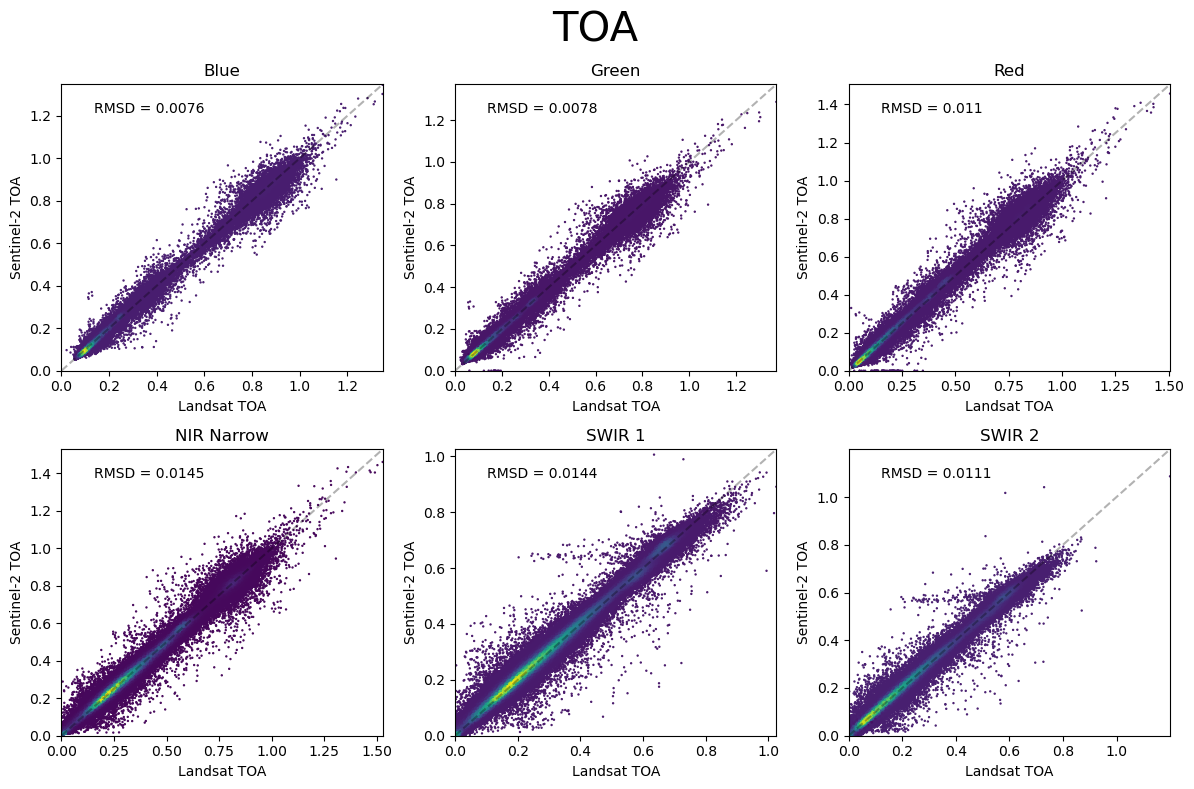

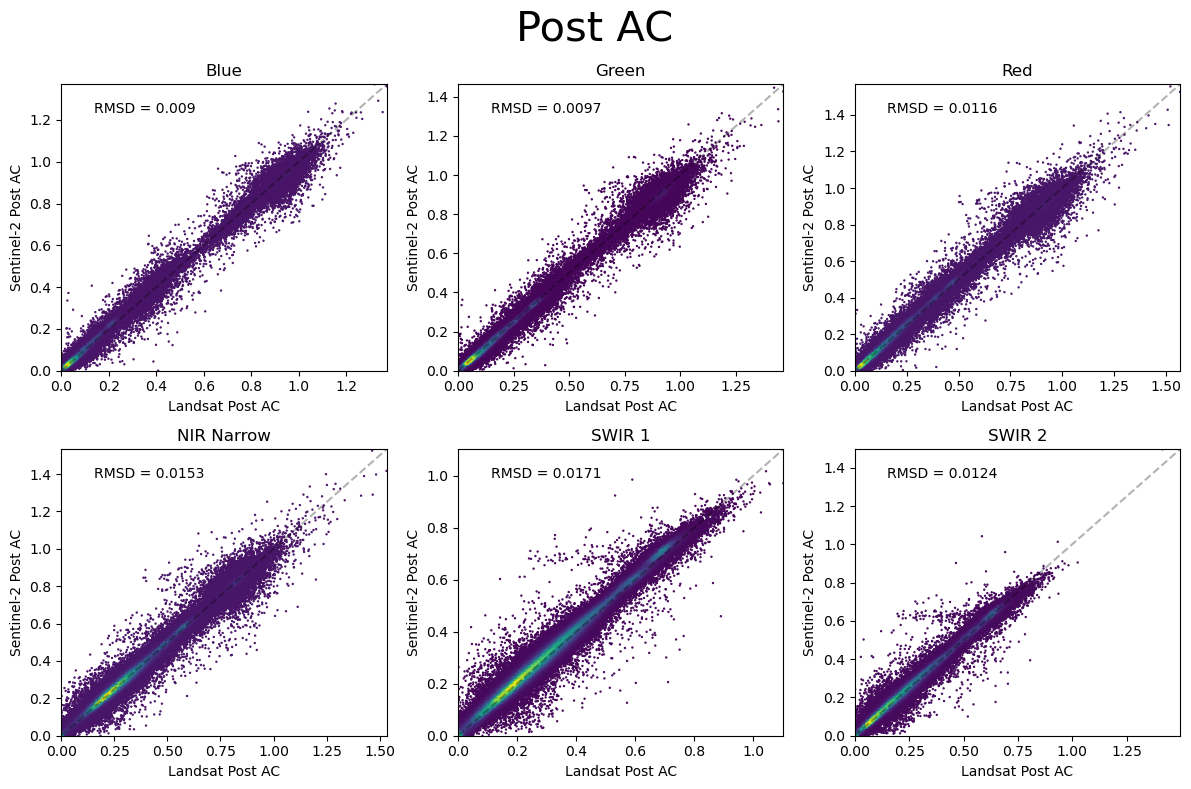

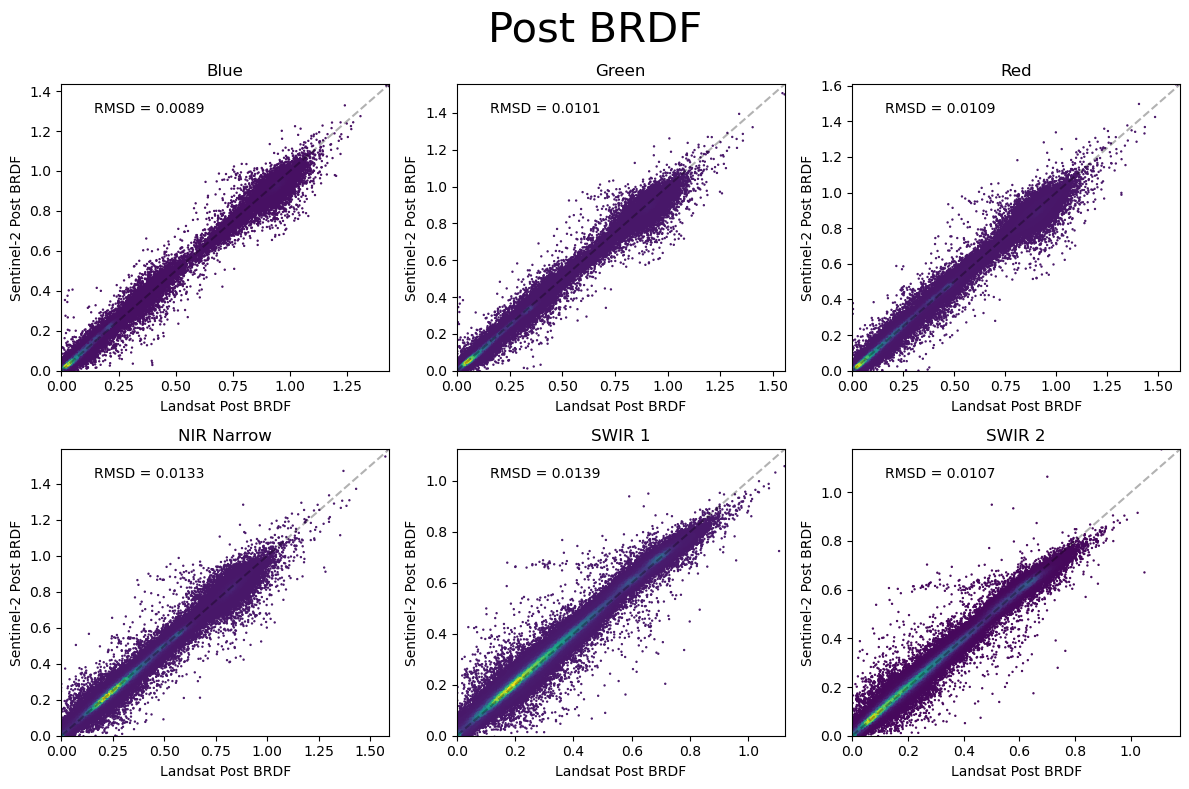

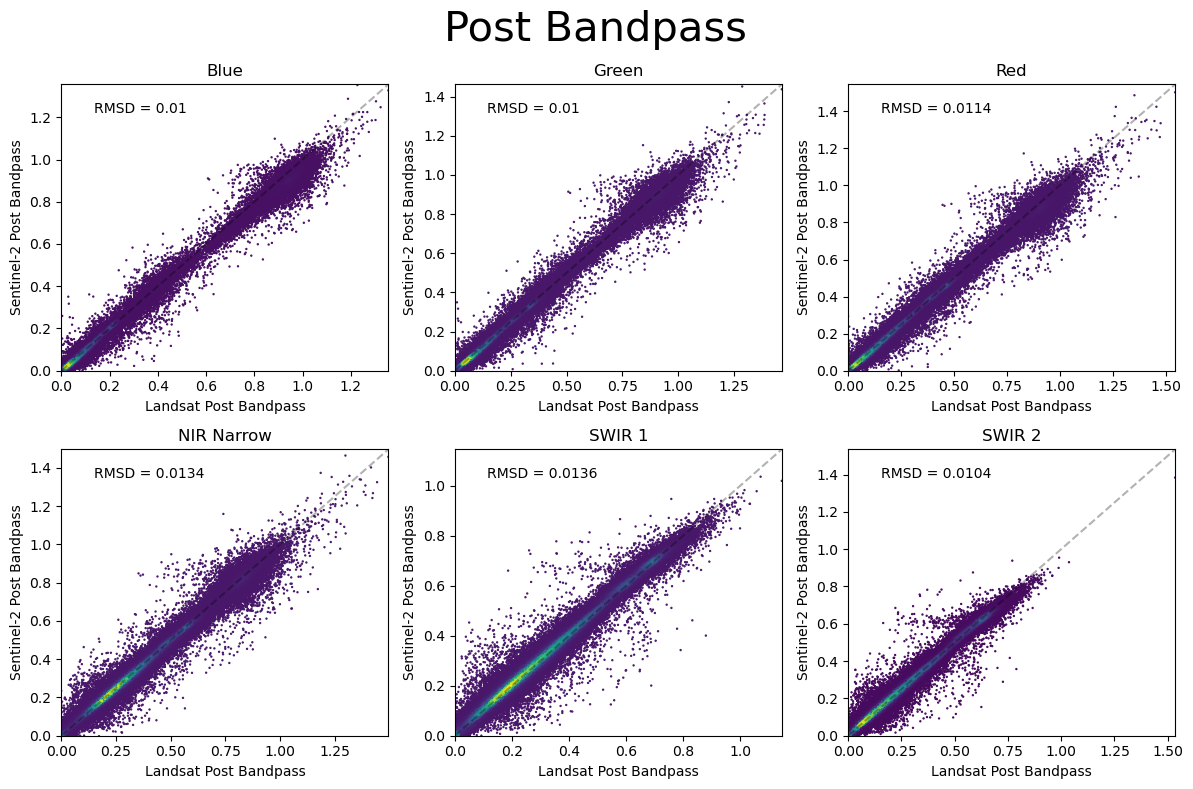

In [56]:
# print("TOA comparison")
sample_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'
toa_mask_dir = os.path.join(sample_dir, "TOA_outlier_mask.npy")
toa_mask = np.load(toa_mask_dir).astype(bool)
n_row = 2
n_col = 3
fig, axs = plt.subplots(n_row, n_col, figsize=(12, 8))
plt_bands_scatter(fig, axs, sample_dir, toa_mask, "TOA")
plt.savefig(os.path.join(sample_dir, 'TOA_allclear.png'), dpi=400)
# print("TOA AC")
sample_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\Intermediate\All_samples"
fig, axs = plt.subplots(n_row, n_col, figsize=(12, 8))
plt_bands_scatter(fig, axs, sample_dir, toa_mask, "Post AC")
plt.savefig(os.path.join(sample_dir, 'PostAC_allclear.png'), dpi=400)
# print("TOA BRDF")
fig, axs = plt.subplots(n_row, n_col, figsize=(12, 8))
plt_bands_scatter(fig, axs, sample_dir, toa_mask, "Post BRDF")
plt.savefig(os.path.join(sample_dir, 'PostBRDF_allclear.png'), dpi=400)
# print("TOA Bandpass")
fig, axs = plt.subplots(n_row, n_col, figsize=(12, 8))
plt_bands_scatter(fig, axs, sample_dir, toa_mask, "Post Bandpass")
plt.savefig(os.path.join(sample_dir, 'PostBandpass_allclear.png'), dpi=400)

# Snow-free observations

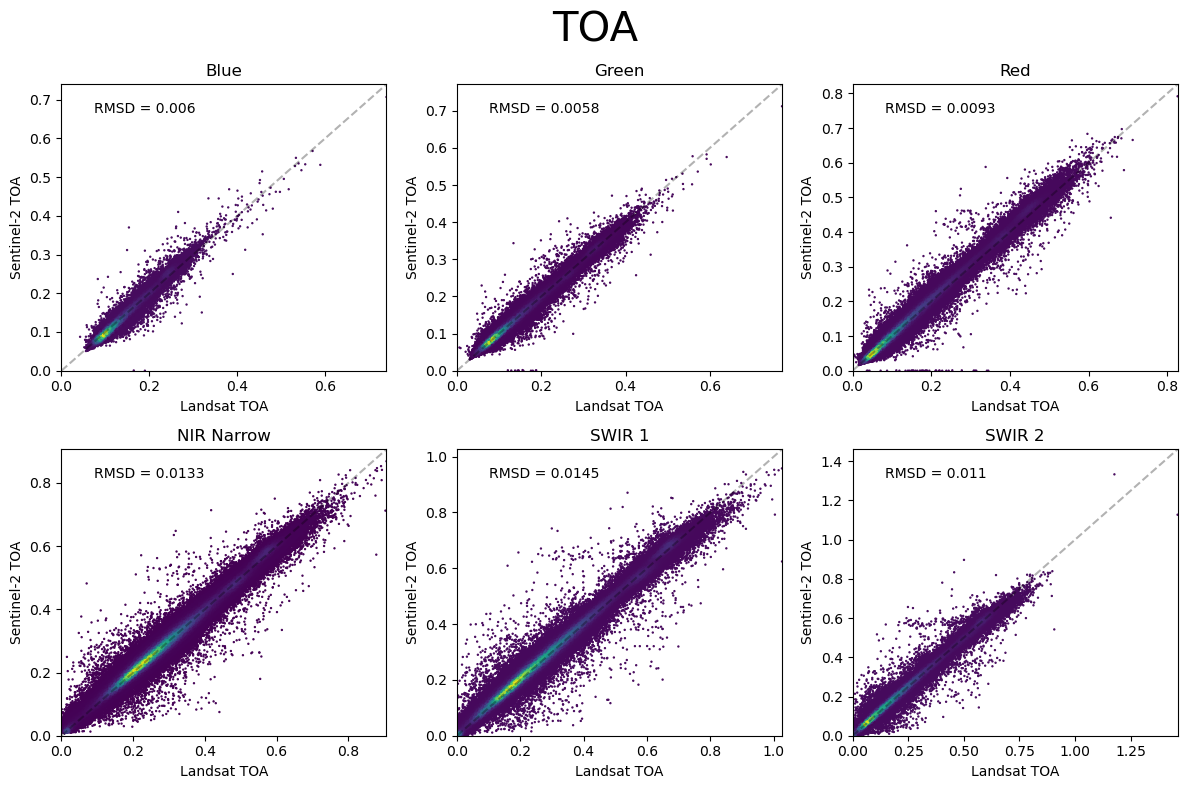

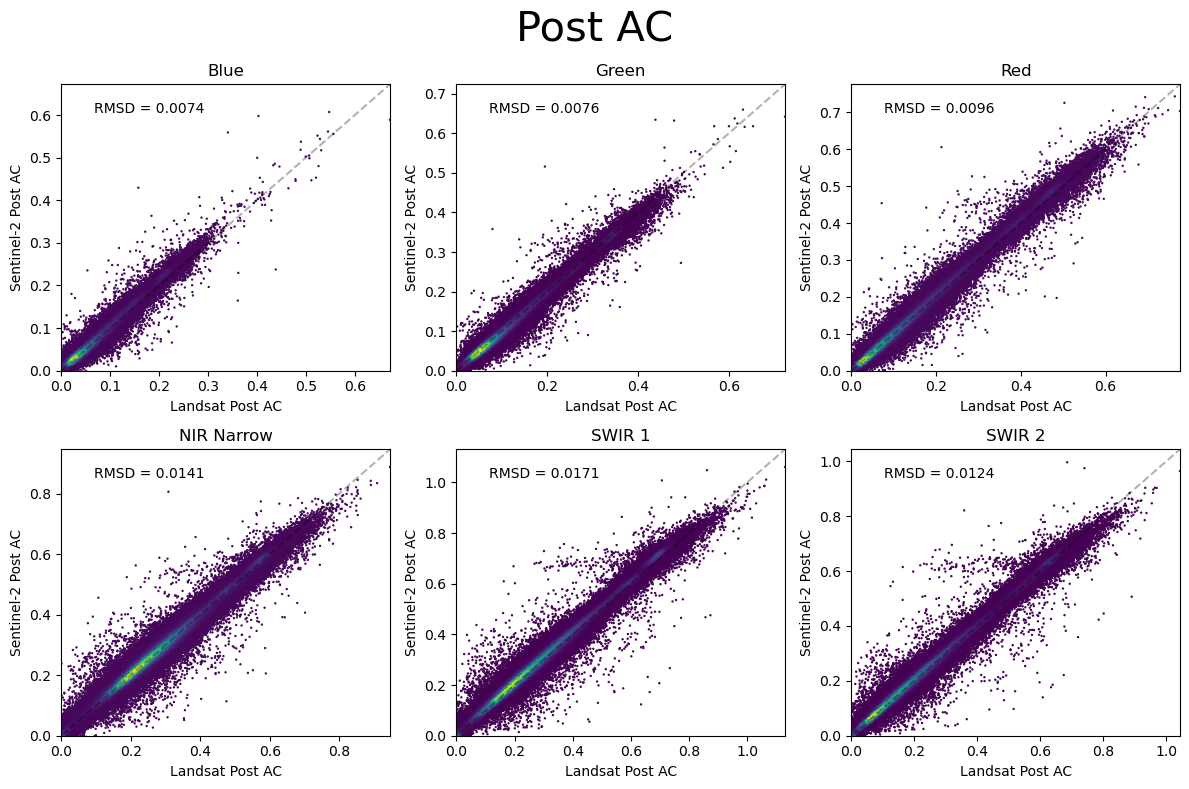

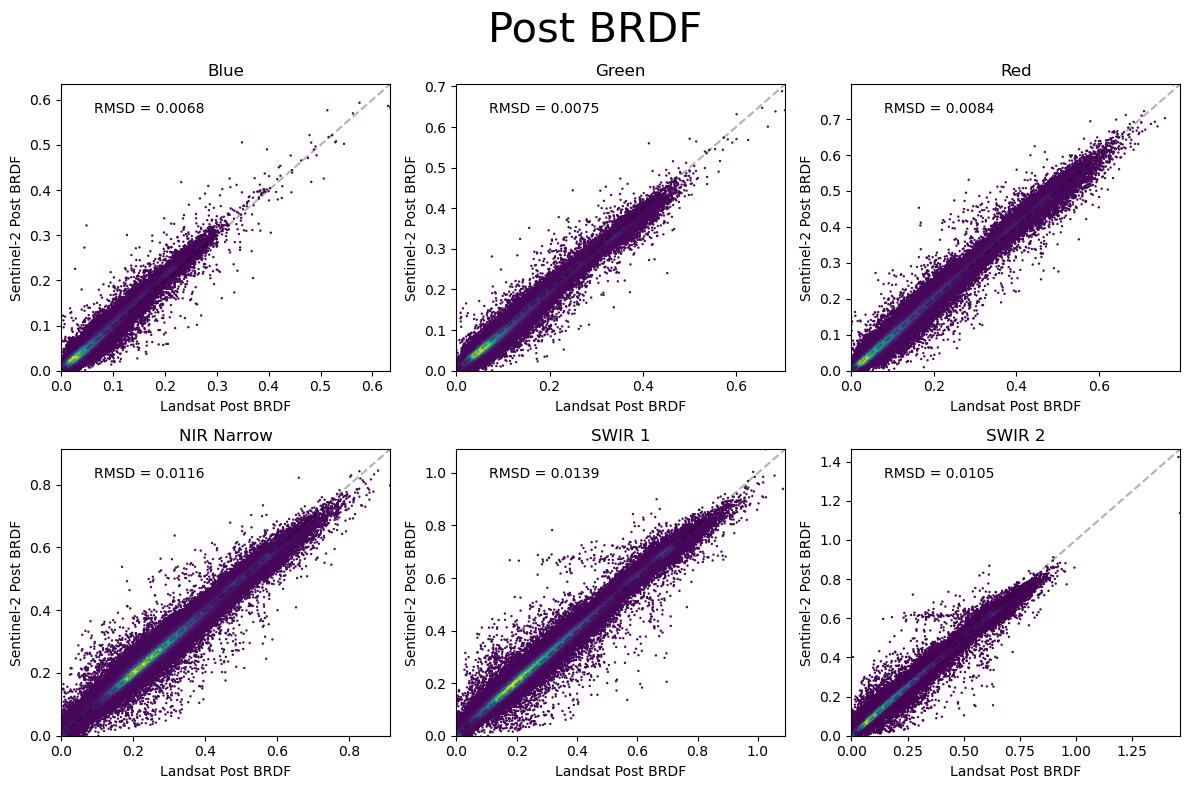

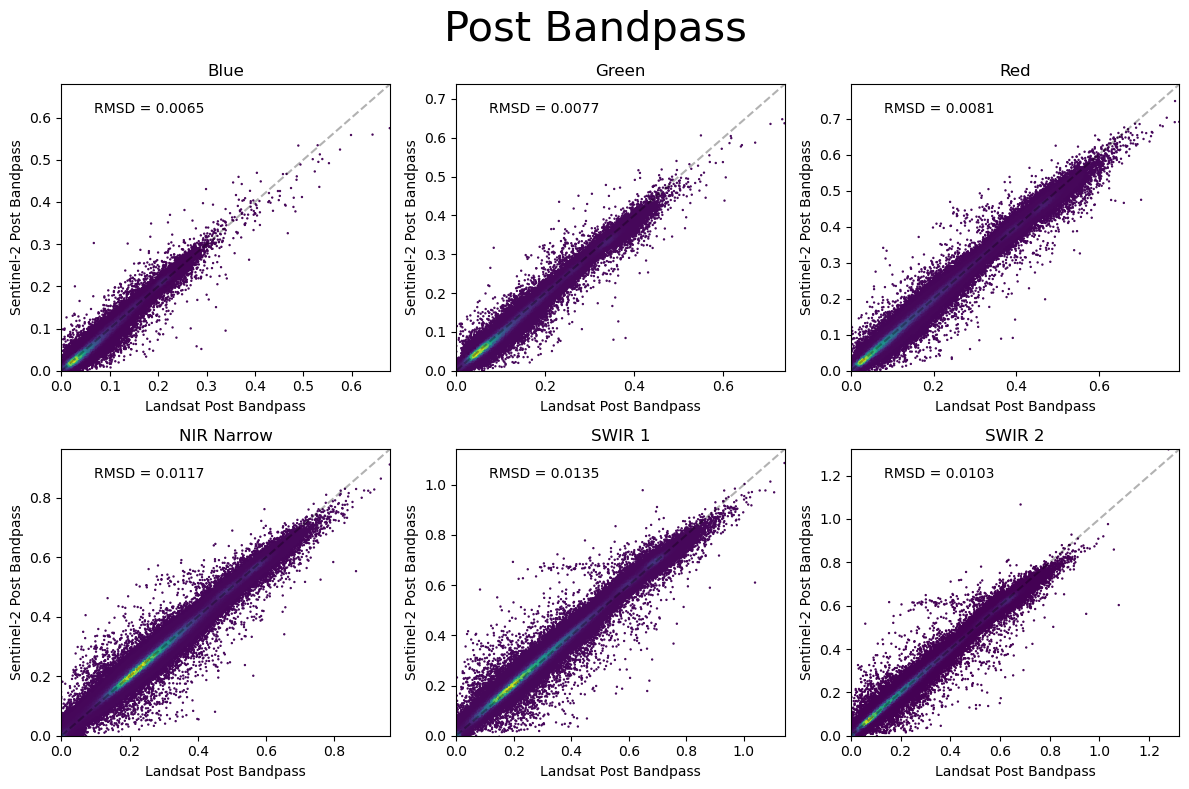

In [30]:
sample_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'
toa_mask_dir = os.path.join(sample_dir, "TOA_outlier_mask.npy")
toa_mask = np.load(toa_mask_dir).astype(bool)
snow_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_snow_mask.npy"
snow_mask = np.load(snow_dir)#.astype(bool)
comb_mask = toa_mask * snow_mask
n_row = 2
n_col = 3
fig, axs = plt.subplots(n_row, n_col, figsize=(12, 8))
plt_bands_scatter(fig, axs, sample_dir, comb_mask, "TOA")
plt.savefig(os.path.join(sample_dir, 'TOA_SnowFree.png'), dpi=400)
sample_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\Intermediate\All_samples"
fig, axs = plt.subplots(n_row, n_col, figsize=(12, 8))
plt_bands_scatter(fig, axs, sample_dir, comb_mask, "Post AC")
plt.savefig(os.path.join(sample_dir, 'PostAC_SnowFree.png'), dpi=400)
fig, axs = plt.subplots(n_row, n_col, figsize=(12, 8))
plt_bands_scatter(fig, axs, sample_dir, comb_mask, "Post BRDF")
plt.savefig(os.path.join(sample_dir, 'PostBRDF_SnowFree.png'), dpi=400)
fig, axs = plt.subplots(n_row, n_col, figsize=(12, 8))
plt_bands_scatter(fig, axs, sample_dir, comb_mask, "Post Bandpass")
plt.savefig(os.path.join(sample_dir, 'PostBandpass_SnowFree.png'), dpi=400)

# Water-free observations

In [16]:
sample_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'
toa_mask_dir = os.path.join(sample_dir, "TOA_outlier_mask.npy")
toa_mask = np.load(toa_mask_dir).astype(bool)
snow_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_snow_mask.npy"
snow_mask = np.load(snow_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask))
water_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_water_mask.npy"
water_mask = np.load(water_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask * water_mask))
date_path = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_Date.npy"
date_arr = np.load(date_path)
tile_path = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_Tile.npy"
tile_arr = np.load(tile_path)
tile_list = np.asarray([ID2TILE[t] for t in tile_arr])
tile_mask = (date_arr == 2021285) * (tile_list == "11SPV")
comb_mask = toa_mask * snow_mask * water_mask * ~tile_mask
print("Total number of valid samples pairs: ", np.sum(comb_mask))

n_row = 2
n_col = 3
fig, axs = plt.subplots(n_row, n_col, figsize=(12, 8))
plt_bands_scatter(fig, axs, sample_dir, comb_mask, "TOA")
plt.savefig(os.path.join(sample_dir, 'TOA_WaterFree.png'), dpi=400)
sample_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\Intermediate\All_samples"
fig, axs = plt.subplots(n_row, n_col, figsize=(12, 8))
plt_bands_scatter(fig, axs, sample_dir, comb_mask, "Post AC")
plt.savefig(os.path.join(sample_dir, 'PostAC_WaterFree.png'), dpi=400)
fig, axs = plt.subplots(n_row, n_col, figsize=(12, 8))
plt_bands_scatter(fig, axs, sample_dir, comb_mask, "Post BRDF")
plt.savefig(os.path.join(sample_dir, 'PostBRDF_WaterFree.png'), dpi=400)
fig, axs = plt.subplots(n_row, n_col, figsize=(12, 8))
plt_bands_scatter(fig, axs, sample_dir, comb_mask, "Post Bandpass")
plt.savefig(os.path.join(sample_dir, 'PostBandpass_WaterFree.png'), dpi=400)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\qzhou2\\C_workdir\\Goden_tile\\TOA\\All_samples\\TOA_outlier_mask.npy'

# Water-free observations by processing steps

Total number of valid samples pairs:  160253969
B01 TOA 0.00486791059758402 0.1357093098755007 0.03587013007471504
[[0.00087598 0.00086908]
 [0.00086908 0.00090237]]
B01 Post AC 0.00532599813924104 0.04792201191410102 0.11113886764161228
[[0.0014664  0.00145326]
 [0.00145326 0.00149677]]
B01 Post BRDF 0.00506210487179885 0.04801152469552876 0.10543520339961784
[[0.00146585 0.00143921]
 [0.00143921 0.00146519]]
B01 Post Bandpass 0.005062497531652386 0.04801152469552876 0.10544338184960514
[[0.00146585 0.00143337]
 [0.00143337 0.00145331]]
B02 TOA 0.004802273815758063 0.1206805038457425 0.03979328609612432
[[0.00146768 0.00155596]
 [0.00155596 0.00168054]]
B02 Post AC 0.005556628192466163 0.05996489024992581 0.09266469377842375
[[0.00221018 0.00231585]
 [0.00231585 0.0024666 ]]
B02 Post BRDF 0.005062496462100103 0.0600888718618884 0.08425014990689167
[[0.002211   0.0022956 ]
 [0.0022956  0.00241891]]
B02 Post Bandpass 0.004785942247708064 0.0600888718618884 0.07964773009399043
[[0.002211

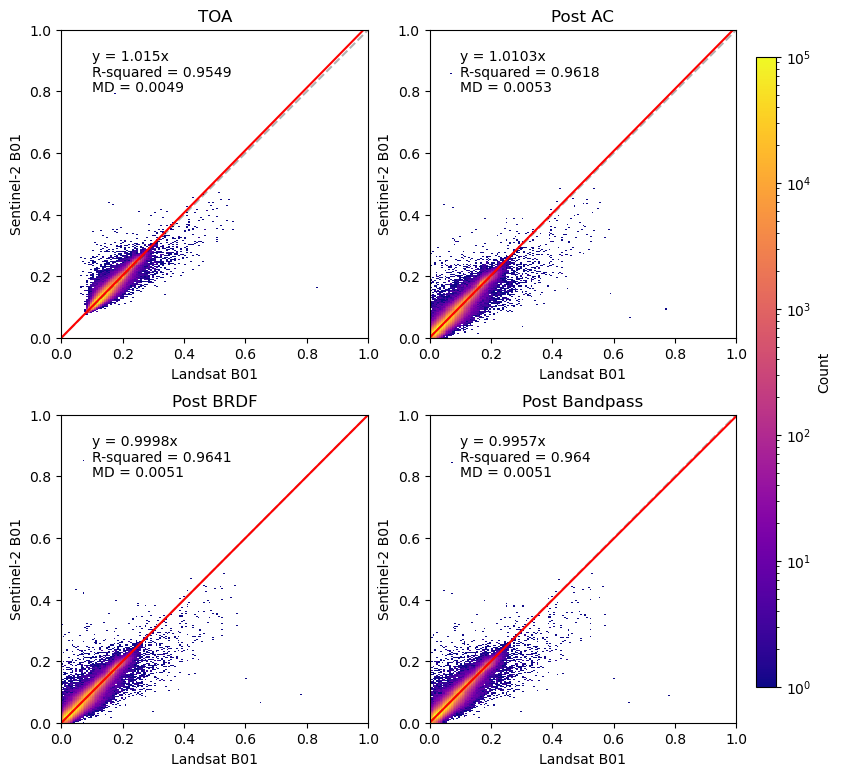

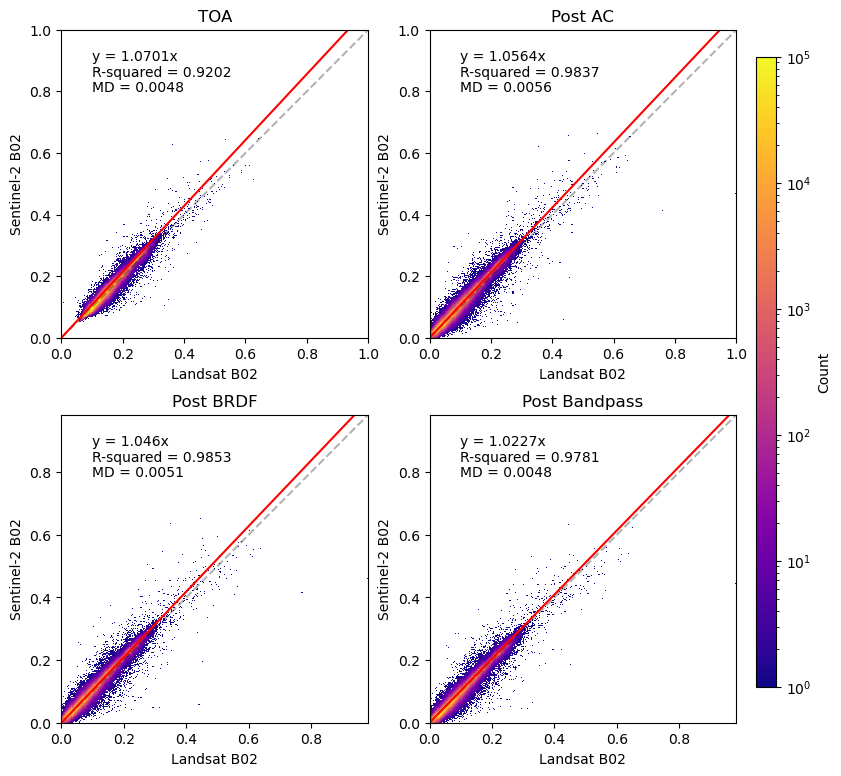

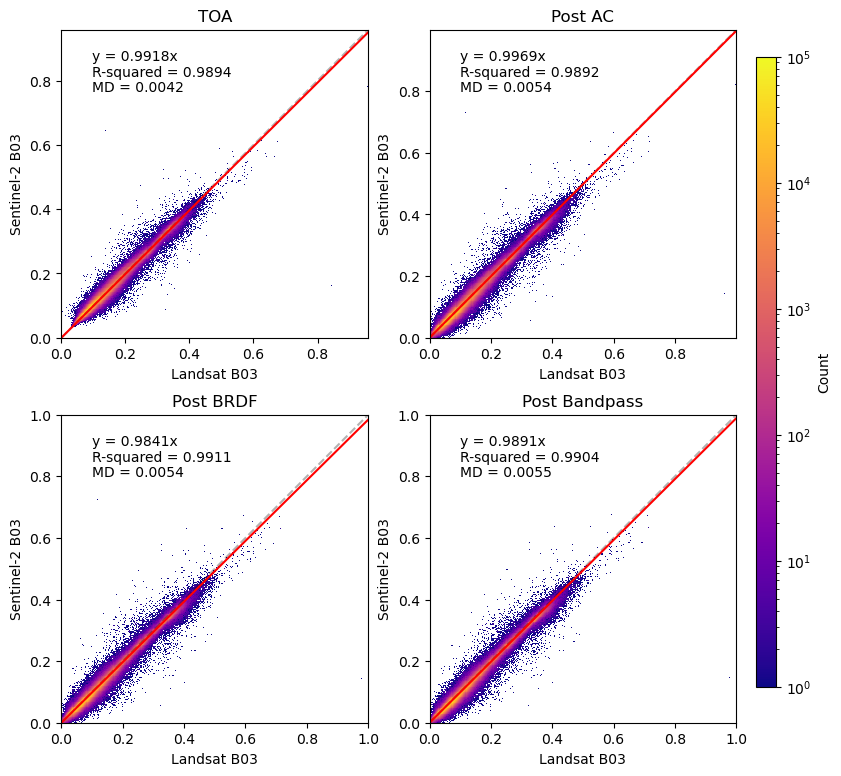

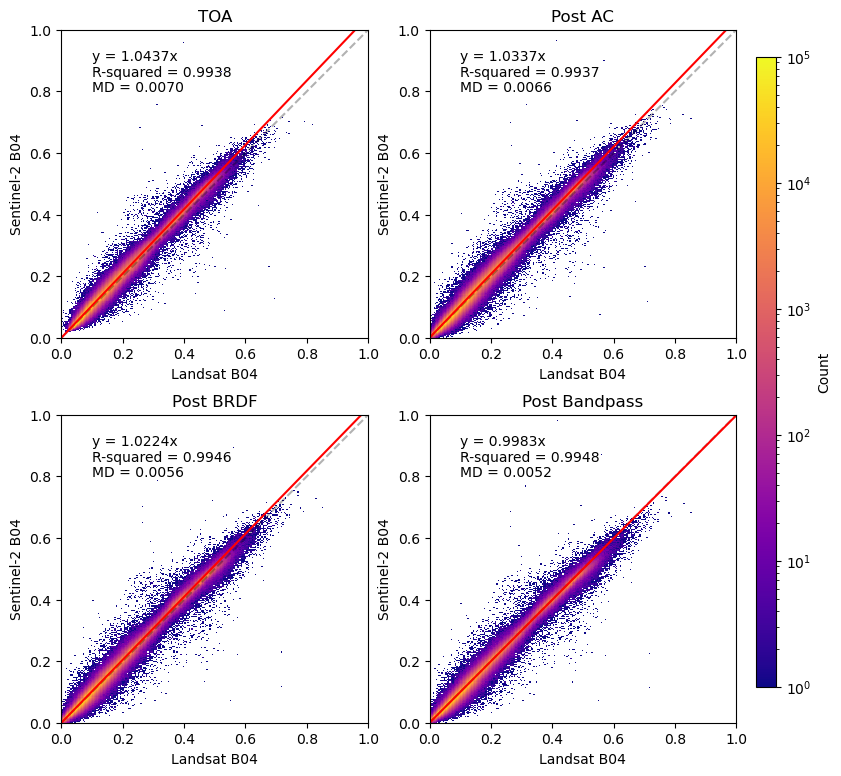

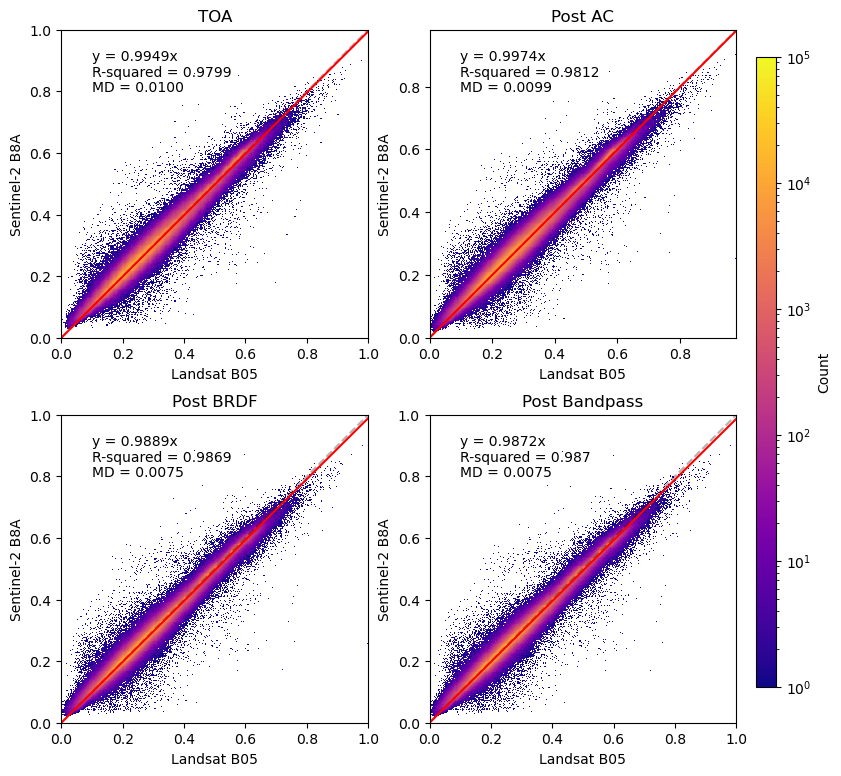

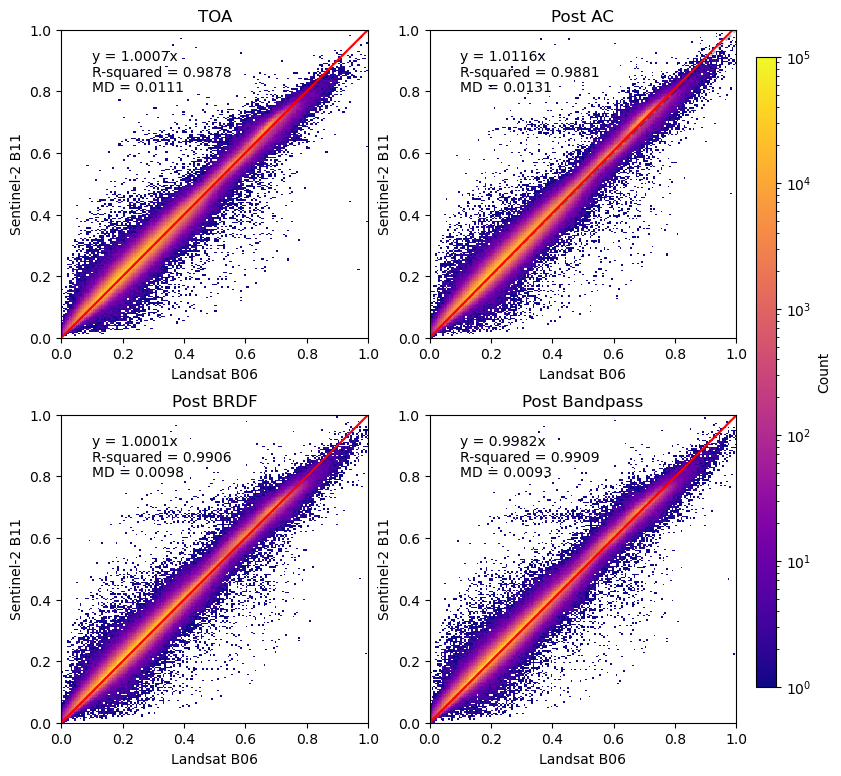

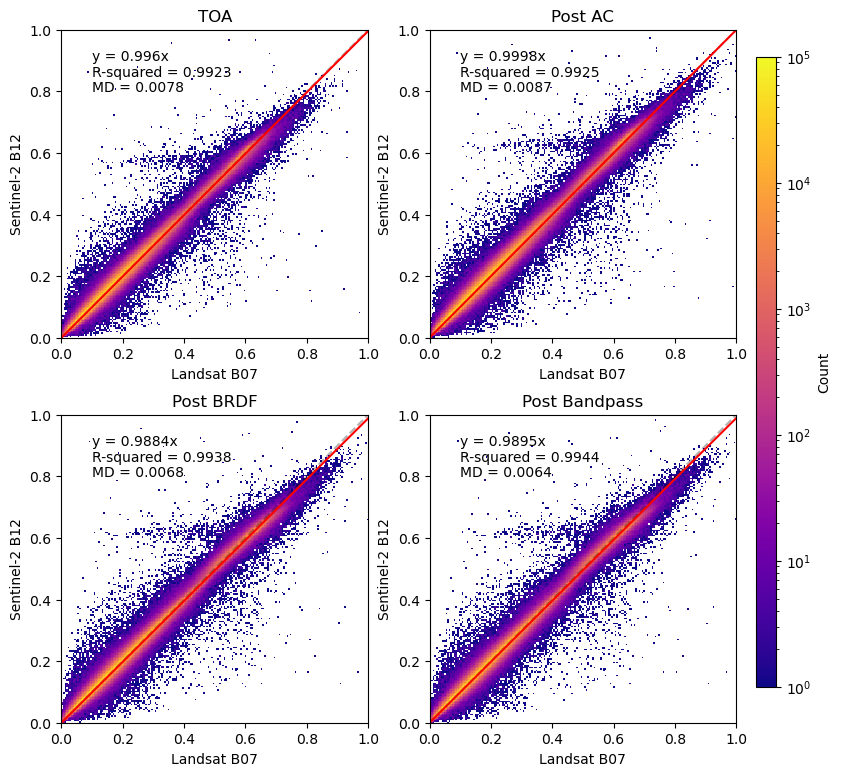

In [9]:
sample_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'
# toa_mask_dir = os.path.join(sample_dir, "TOA_outlier_mask.npy")
# toa_mask = np.load(toa_mask_dir).astype(bool)
snow_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_snow_mask.npy"
snow_mask = np.load(snow_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask))
water_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_water_mask.npy"
water_mask = np.load(water_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask * water_mask))
date_path = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_Date.npy"
date_arr = np.load(date_path)
tile_path = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_Tile.npy"
tile_arr = np.load(tile_path)
tile_list = np.asarray([ID2TILE[t] for t in tile_arr])
tile_ex = [('11SPV', 2021285), ('55HEU', 2021009), ('55JGH', 2022012), 
              ('55JGH', 2022172), ('55JGH', 2022332), ('55JHM', 2021137),
             ('55JHM', 2021217)]
tile_mask = np.zeros_like(snow_mask, dtype=bool)
for t in tile_ex:
    tile_mask = tile_mask | ((date_arr == t[1]) * (tile_list == t[0]))
# tile_mask = (date_arr == 2021285) * (tile_list == "11SPV")
comb_mask = snow_mask * water_mask * ~tile_mask #toa_mask * 
print("Total number of valid samples pairs: ", np.sum(comb_mask))

err_idx = 'mad'
reg_med='RMA'
n_row = 2
n_col = 2
# band = "B05"
for band in ["B01", "B02", "B03", "B04", "B05", "B06", "B07"]:
    fig, axs = plt.subplots(n_row, n_col, figsize=(10, 9))
    plt_step_scatter(fig, axs, comb_mask, band, reg_med=reg_med,err_idx=err_idx)
    # plt.savefig(os.path.join(sample_dir, f'{band}_WaterFree_{reg_med}_fromorigin_{err_idx}.png'), dpi=400)

# sample_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\Intermediate\All_samples"
# fig, axs = plt.subplots(n_row, n_col, figsize=(8, 8))
# plt_bands_scatter(fig, axs, sample_dir, comb_mask, "Post AC")
# plt.savefig(os.path.join(sample_dir, 'PostAC_WaterFree.png'), dpi=400)
# fig, axs = plt.subplots(n_row, n_col, figsize=(8, 8))
# plt_bands_scatter(fig, axs, sample_dir, comb_mask, "Post BRDF")
# plt.savefig(os.path.join(sample_dir, 'PostBRDF_WaterFree.png'), dpi=400)
# fig, axs = plt.subplots(n_row, n_col, figsize=(8, 8))
# plt_bands_scatter(fig, axs, sample_dir, comb_mask, "Post Bandpass")
# plt.savefig(os.path.join(sample_dir, 'PostBandpass_WaterFree.png'), dpi=400)

# Water-free observation ERR by processing steps

Total number of valid samples pairs:  162908616


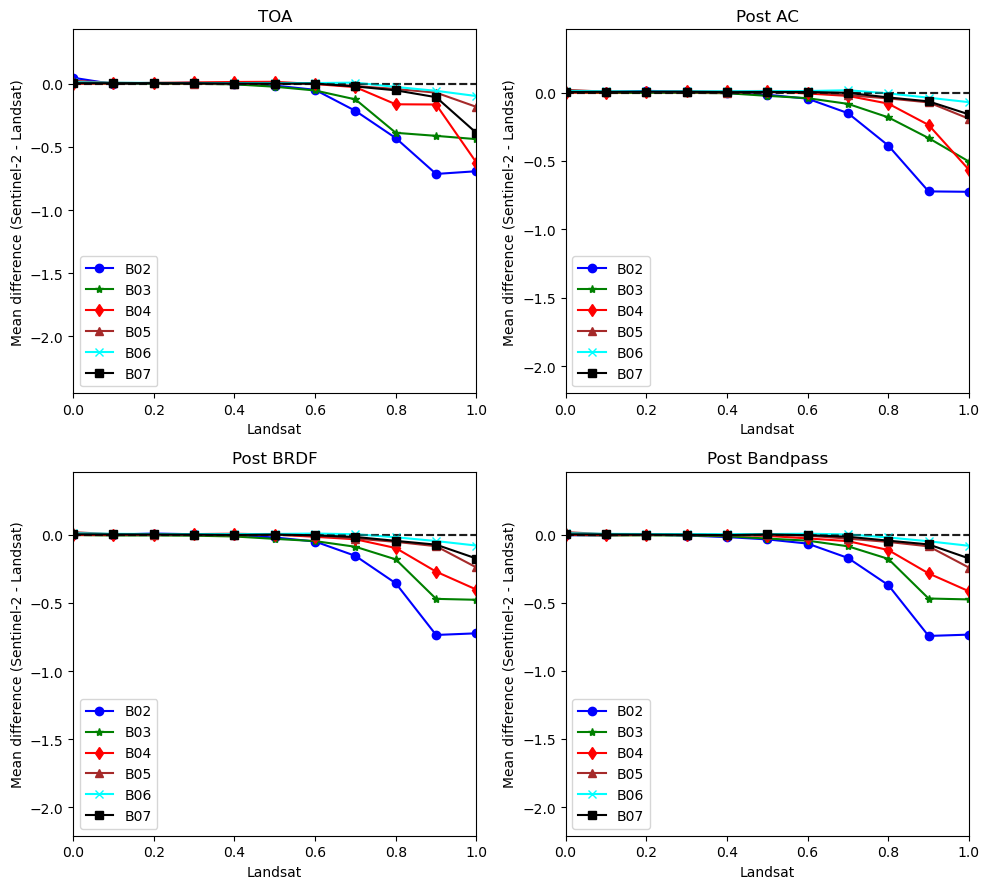

In [18]:
sample_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'
# toa_mask_dir = os.path.join(sample_dir, "TOA_outlier_mask.npy")
# toa_mask = np.load(toa_mask_dir).astype(bool)
snow_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_snow_mask.npy"
snow_mask = np.load(snow_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask))
water_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_water_mask.npy"
water_mask = np.load(water_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask * water_mask))
date_path = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_Date.npy"
date_arr = np.load(date_path)
tile_path = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_Tile.npy"
tile_arr = np.load(tile_path)
tile_list = np.asarray([ID2TILE[t] for t in tile_arr])
tile_ex = [('11SPV', 2021285), ('55HEU', 2021009), ('55JGH', 2022012), 
              ('55JGH', 2022172), ('55JGH', 2022332), ('55JHM', 2021137),
             ('55JHM', 2021217)]
tile_mask = np.zeros_like(snow_mask, dtype=bool)
for t in tile_ex:
    tile_mask = tile_mask | ((date_arr == t[1]) * (tile_list == t[0]))
# tile_mask = (date_arr == 2021285) * (tile_list == "11SPV")
comb_mask = snow_mask * water_mask * ~tile_mask # toa_mask * 
print("Total number of valid samples pairs: ", np.sum(comb_mask))

mad_list = []
for band in HLS_L8:
    mad_list.append(cal_mad(comb_mask, band))
df = pd.DataFrame(mad_list)
# print(df)
df.to_csv(os.path.join(sample_dir, 'MAD_by_steps.csv'))

# md_list = []
# for band in HLS_L8:
#     md_list.append(cal_md(comb_mask, band))
# df = pd.DataFrame(md_list)
# df.to_csv(os.path.join(sample_dir, 'MD_by_steps.csv'))

n_row = 2
n_col = 2
fig, axs = plt.subplots(n_row, n_col, figsize=(10, 9))
for band in HLS_L8:
    plt_md(fig, axs, comb_mask, band)
plt.savefig(os.path.join(sample_dir, f'WaterFree_meandiff.png'), dpi=400)

# rmsd_list = []
# for band in HLS_L8:
#     rmsd_list.append(cal_rmsd(comb_mask, band))
# df = pd.DataFrame(rmsd_list)
# df.to_csv(os.path.join(sample_dir, 'RMSD_by_steps.csv'))

# Water-free observations by processing steps (only opsite view azimuth angle)

Total number of valid samples pairs:  37431644


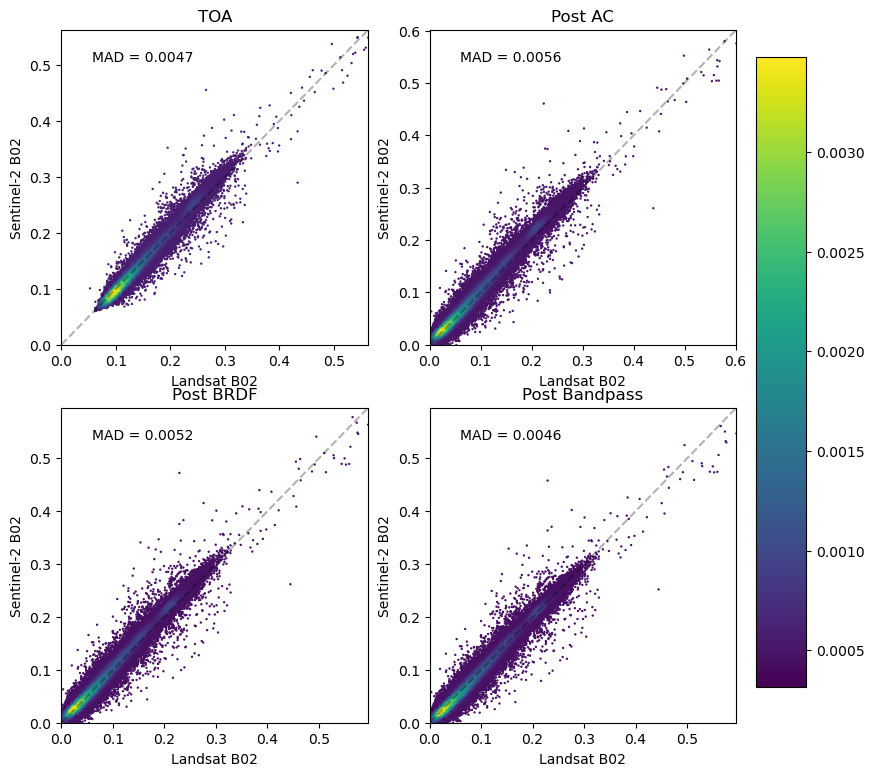

In [17]:
sample_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'
# toa_mask_dir = os.path.join(sample_dir, "TOA_outlier_mask.npy")
# toa_mask = np.load(toa_mask_dir).astype(bool)
snow_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_snow_mask.npy"
snow_mask = np.load(snow_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask))
water_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_water_mask.npy"
water_mask = np.load(water_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask * water_mask))
date_path = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_Date.npy"
date_arr = np.load(date_path)
tile_path = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_Tile.npy"
tile_arr = np.load(tile_path)
tile_list = np.asarray([ID2TILE[t] for t in tile_arr])
tile_ex = [('11SPV', 2021285), ('55HEU', 2021009), ('55JGH', 2022012), 
              ('55JGH', 2022172), ('55JGH', 2022332), ('55JHM', 2021137),
             ('55JHM', 2021217)]
tile_mask = np.zeros_like(snow_mask, dtype=bool)
for t in tile_ex:
    tile_mask = tile_mask | ((date_arr == t[1]) * (tile_list == t[0]))
# tile_mask = (date_arr == 2021285) * (tile_list == "11SPV")
va_path = os.path.join(r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_L30_view_azimuth.npy")
ang_l = 0.01 * np.load(va_path)
sa_path = os.path.join(r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_S30_view_azimuth.npy")
ang_s = 0.01 * np.load(sa_path)

vz_path = os.path.join(r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_L30_view_zenith.npy")
ang_lz = 0.01 * np.load(vz_path)
sz_path = os.path.join(r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_S30_view_zenith.npy")
ang_sz = 0.01 * np.load(sz_path)
ang_mask_vz = (ang_lz > 3) & (ang_sz > 3) # greater than 3 view zenith angle

# ang_mask = ((ang_l < 180) & (ang_s >= 180)) | ((ang_l >= 180) & (ang_s < 180)) # opposite view azimuth angle
ang_mask = ((ang_l < 180) & (ang_s < 180)) | ((ang_l >= 180) & (ang_s >= 180)) # same view azimuth angle
comb_mask = snow_mask * water_mask * ~tile_mask * ang_mask * ang_mask_vz # toa_mask * 
print("Total number of valid samples pairs: ", np.sum(comb_mask))

n_row = 2
n_col = 2
band = "B02"
fig, axs = plt.subplots(n_row, n_col, figsize=(10, 9))
plt_step_scatter(fig, axs, comb_mask, band)
# plt.savefig(os.path.join(sample_dir, f'{band}_WaterFree_opView_VZgt3.png'), dpi=400)
plt.savefig(os.path.join(sample_dir, f'{band}_WaterFree_sameView_VZgt3.png'), dpi=400)

In [24]:
def plt_bands_scatter_stra(fig, axs, sample_dir, sample_mask, band, res):
    sub_pop = 0.01
    marker_size = 0.5
    lc_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\MODIS_LC_2020\Layer1\Merged_filtered_samp_LC_LC.npy"
    lc_mask = np.load(lc_dir)#.astype(bool)
    # for i, b in enumerate(ind_list):
    for i in range(10):
        # l_path = os.path.join(sample_dir, f"Merged_filtered_samp_L30_sr_nbar_{index}.npy")
        # l_arr = np.load(l_path)[sample_mask * (lc_mask == i + 1)]
        # s_path = os.path.join(sample_dir, f"Merged_filtered_samp_S30_sr_nbar_bp_{index}.npy")
        # s_arr = np.load(s_path)[sample_mask * (lc_mask == i + 1)]
        l_path = os.path.join(sample_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{band}.npy")
        l_arr = sr_scale * np.load(l_path)[sample_mask * (lc_mask == i + 1)]
        s_path = os.path.join(sample_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{L8_2_S2[band]}.npy")
        s_arr = sr_scale * np.load(s_path)[sample_mask * (lc_mask == i + 1)]
        # sample_mask = sample_mask * (lc_mask == i + 1)
        # print(IGBP_LC[i + 1], ": ", np.sum(sample_mask * (lc_mask == i + 1)))
        
        sample_idx = (np.random.rand(l_arr.shape[0]) < sub_pop) * np.isfinite(l_arr) * np.isfinite(s_arr)
        # print("Plot number of samples: ", np.sum(sample_idx))
        l_arr = l_arr[sample_idx]
        s_arr = s_arr[sample_idx]

        xy = np.vstack([l_arr, s_arr])
        z = gaussian_kde(xy)(xy)
        # z = np.sqrt(kde_arr + 2*np.abs(np.min(kde_arr))) # stretch color
        
        # max_val = max(np.percentile(l_arr, 99), np.percentile(s_arr, 99))
        min_val = max(np.percentile(l_arr, 1), np.percentile(s_arr, 1))
        max_val = max(np.max(l_arr), np.max(s_arr))
        max_val = min(max_val, 1.0)
        # mse = np.square(np.subtract(l_arr, s_arr)).mean()
        # rmse = math.sqrt(mse)
        mad = np.mean(np.abs(l_arr - s_arr))
        axs[i//n_col, i%n_col].scatter(l_arr, s_arr, c=z, s=marker_size)#
        # axs[i//n_col, i%n_col].annotate(f"MAD = {np.round(mad, 3)}", xy=(max_val * 0.1, max_val * 0.9))
        axs[i//n_col, i%n_col].set_title(IGBP_LC[i + 1] + f"\nMAD = {np.round(mad, 3)}")
        axs[i//n_col, i%n_col].set_xlim((min_val, max_val))
        axs[i//n_col, i%n_col].set_ylim((min_val, max_val))
        axs[i//n_col, i%n_col].set_xlabel(f'Landsat {L8_bandname[band]}')
        axs[i//n_col, i%n_col].set_ylabel(f'Sentinel-2 {L8_bandname[band]}')
        axs[i//n_col, i%n_col].plot([0, max_val], [0, max_val], 'k--', alpha=0.3)
        # axs[i//n_col, i%n_col].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)

    # fig.delaxes(axs[n_row-1][n_col-1])
    fig.suptitle(res, fontsize=30)
    # fig.delaxes(axs[n_row-1][n_col-1])
    # fig.suptitle(b, fontsize=30)
    plt.tight_layout()

Total number of valid samples pairs:  163379892


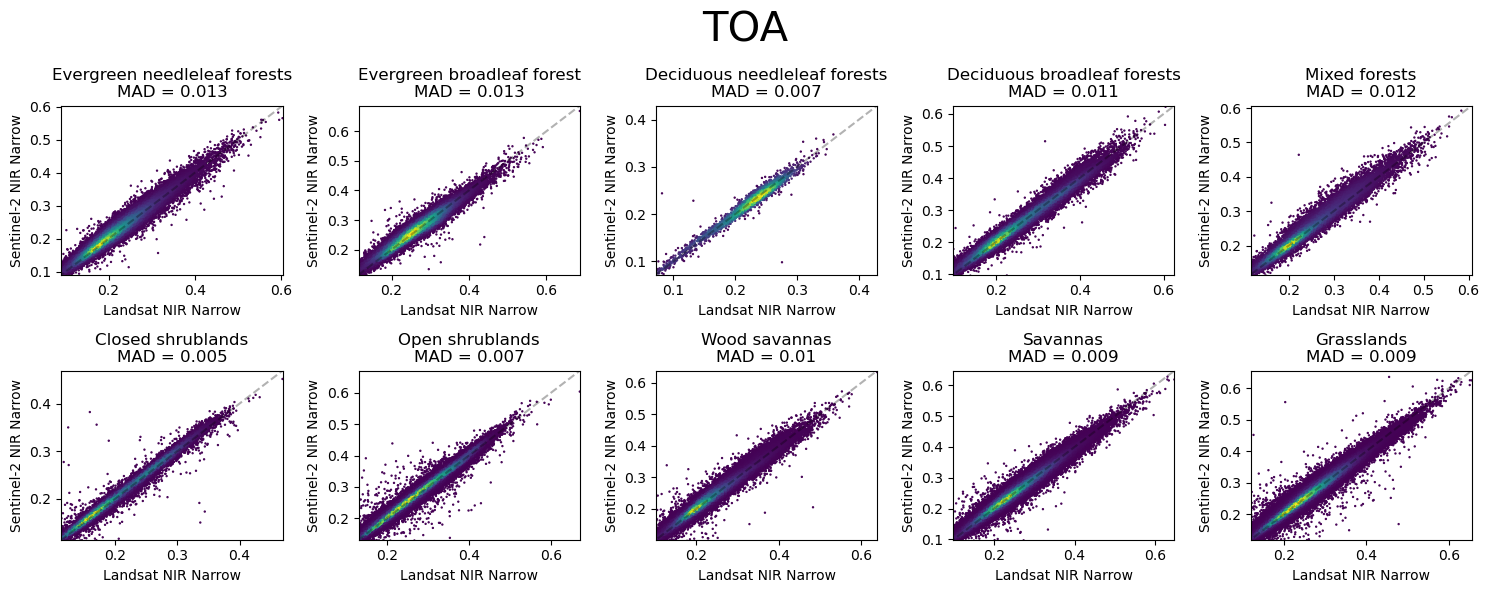

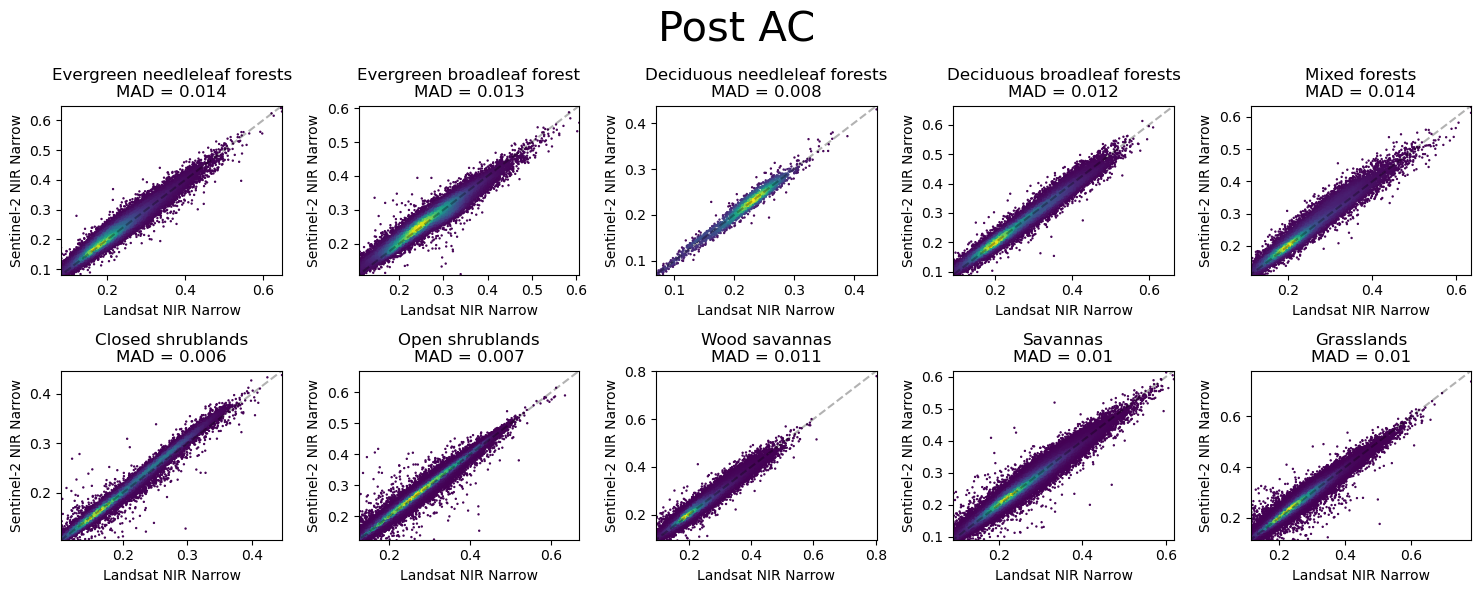

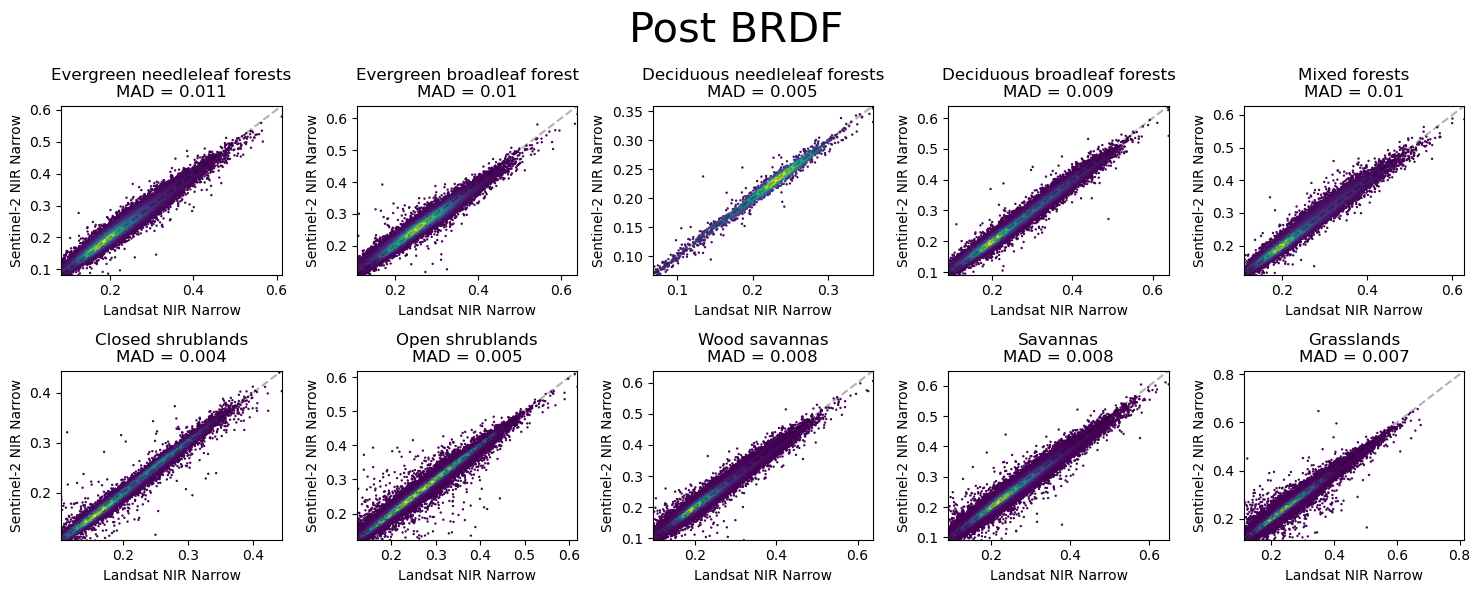

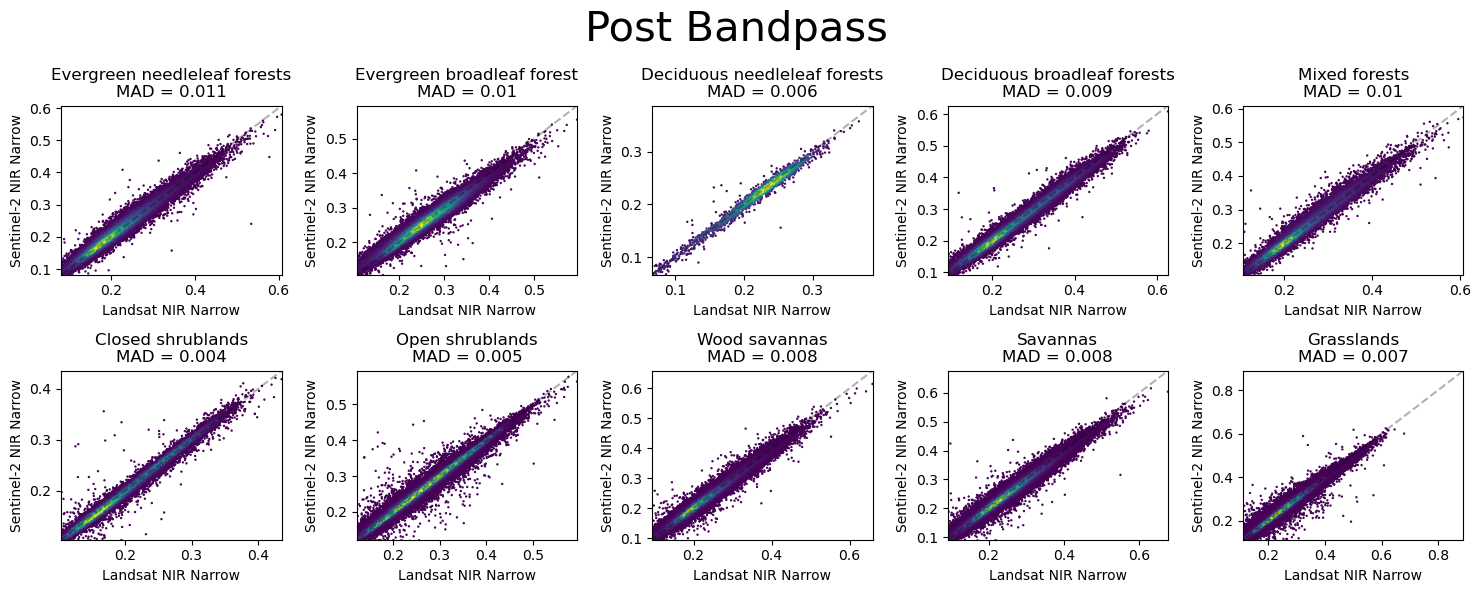

In [25]:
sample_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'
# toa_mask_dir = os.path.join(sample_dir, "TOA_outlier_mask.npy")
# toa_mask = np.load(toa_mask_dir).astype(bool)
snow_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_snow_mask.npy"
snow_mask = np.load(snow_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask))
water_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_water_mask.npy"
water_mask = np.load(water_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask * water_mask))
comb_mask = snow_mask * water_mask # toa_mask * 
print("Total number of valid samples pairs: ", np.sum(comb_mask))
n_row = 2
n_col = 5
band = "B05"
# sample_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\Intermediate\All_samples"
# fig, axs = plt.subplots(n_row, n_col, figsize=(15, 6))
# plt_bands_scatter_stra(fig, axs, sample_dir, comb_mask, band, res)
# plt.savefig(os.path.join(sample_dir, 'VI.png'), dpi=400)

fig, axs = plt.subplots(n_row, n_col, figsize=(15, 6))
plt_bands_scatter_stra(fig, axs, sample_dir, comb_mask, band, "TOA")
plt.savefig(os.path.join(sample_dir, f'TOA_WaterFree_{band}_strata.png'), dpi=400)
sample_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\Intermediate\All_samples"
fig, axs = plt.subplots(n_row, n_col, figsize=(15, 6))
plt_bands_scatter_stra(fig, axs, sample_dir, comb_mask, band, "Post AC")
plt.savefig(os.path.join(sample_dir, f'PostAC_WaterFree_{band}_strata.png'), dpi=400)
fig, axs = plt.subplots(n_row, n_col, figsize=(15, 6))
plt_bands_scatter_stra(fig, axs, sample_dir, comb_mask, band, "Post BRDF")
plt.savefig(os.path.join(sample_dir, f'PostBRDF_WaterFree_{band}_strata.png'), dpi=400)
fig, axs = plt.subplots(n_row, n_col, figsize=(15, 6))
plt_bands_scatter_stra(fig, axs, sample_dir, comb_mask, band, "Post Bandpass")
plt.savefig(os.path.join(sample_dir, f'PostBandpass_WaterFree_{band}_strata.png'), dpi=400)

# Land cover population count

In [41]:
sample_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'
toa_mask_dir = os.path.join(sample_dir, "TOA_outlier_mask.npy")
toa_mask = np.load(toa_mask_dir).astype(bool)
snow_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_snow_mask.npy"
snow_mask = np.load(snow_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask))
water_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_water_mask.npy"
water_mask = np.load(water_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask * water_mask))
date_path = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_Date.npy"
date_arr = np.load(date_path)
tile_path = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_Tile.npy"
tile_arr = np.load(tile_path)
# print(np.max(date_arr), np.max(tile_arr))
tile_list = np.asarray([ID2TILE[t] for t in tile_arr])
tile_mask = (date_arr == 2021285) * (tile_list == "11SPV")
comb_mask = toa_mask * snow_mask * water_mask * ~tile_mask
print("Total number of valid samples pairs: ", np.sum(comb_mask))

lc_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\MODIS_LC_2020\Layer1\Merged_filtered_samp_LC_LC.npy"
lc_mask = np.load(lc_dir)[comb_mask]#.astype(bool)

# Get unique date-tile combination
date_arr = date_arr[comb_mask]
tile_arr = tile_arr[comb_mask]
# index_arr = date_arr * 100 + tile_arr
# _, indices = np.unique(index_arr, return_index=True)
# print(indices.shape)

# Get unique coords-tile combination
x_path = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_x.npy"
x_arr = np.load(x_path)[comb_mask]
y_path = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_y.npy"
y_arr = np.load(y_path)[comb_mask]
print(x_arr[:2], y_arr[:2])

idx0 = np.char.add(np.char.mod('%d', tile_arr), np.char.mod('%d', x_arr))
idx1 = np.char.add(idx0, np.char.mod('%d', y_arr)) 
print(idx1[:2])
_, indices = np.unique(idx1, return_index=True)
print(np.unique(lc_mask[indices], return_counts=True))

Total number of valid samples pairs:  162907485
[625185. 625215.] [7000005. 7000005.]
['506251857000005' '506252157000005']
(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17, 255], dtype=uint8), array([ 1607133,  2422537,    56815,  1758890,   857835,   713229,
        4024982,  2630484,  4690467,  6389460,   213420,  4378674,
         215234,    69706,     4129,  2290127,     7271, 10841643],
      dtype=int64))


# Abs(L30 - S30) in relation to view angle (forward or backward view)

In [32]:
def plt_banddiff_vs_ang(fig, axs, sample_dir, sample_mask, res):
    sub_pop = 0.01
    marker_size = 0.5
    for i, b in enumerate(HLS_L8):
        l_path = os.path.join(sample_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{b}.npy")
        l_arr = sr_scale * np.load(l_path)[sample_mask]
        s_path = os.path.join(sample_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{L8_2_S2[b]}.npy")
        s_arr = sr_scale * np.load(s_path)[sample_mask]
        diff_arr = np.abs(l_arr - s_arr)
        #  azimuth diff
        va_path = os.path.join(r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_L30_view_azimuth.npy")
        va_arr = 0.01 * np.load(va_path)[sample_mask]
        sa_path = os.path.join(r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_S30_view_azimuth.npy")
        sa_arr = 0.01 * np.load(sa_path)[sample_mask]
        ang_arr = sa_arr - va_arr
        if i== 0:
            # print("Total number of samples: ", l_arr.shape)
            sample_idx = np.random.rand(l_arr.shape[0]) < sub_pop
            # print("Plot number of samples: ", np.sum(sample_idx))
        diff_arr = diff_arr[sample_idx]
        ang_arr = ang_arr[sample_idx]

        # max_val = max(np.max(l_arr), np.max(s_arr))
        # mse = np.square(np.subtract(l_arr, s_arr)).mean()
        # rmse = math.sqrt(mse)
        # sns.boxplot(ax=axs[i//n_col, i%n_col], x=ang_arr, y=diff_arr)
        axs[i//n_col, i%n_col].scatter(ang_arr, diff_arr, s=marker_size)#
        # axs[i//n_col, i%n_col].scatter(l_arr, s_arr, c=kde_arr, s=marker_size)#
        # axs[i//n_col, i%n_col].annotate(f"RMSD = {np.round(rmse, 4)}", xy=(max_val * 0.1, max_val * 0.9))
        axs[i//n_col, i%n_col].set_title(L8_bandname[b])
        # axs[i//n_col, i%n_col].set_xlim((0, max_val))
        # axs[i//n_col, i%n_col].set_ylim((0, max_val))
        # axs[i//n_col, i%n_col].plot([0, max_val], [0, max_val], 'k--', alpha=0.3)

    for ax in axs.flat:
        ax.set(xlabel='S_view_azi - L_view_azi', ylabel='Abs(S30 - L30)')

#     # fig.delaxes(axs[n_row-1][n_col-1])
#     fig.suptitle(res, fontsize=30)
    plt.tight_layout()

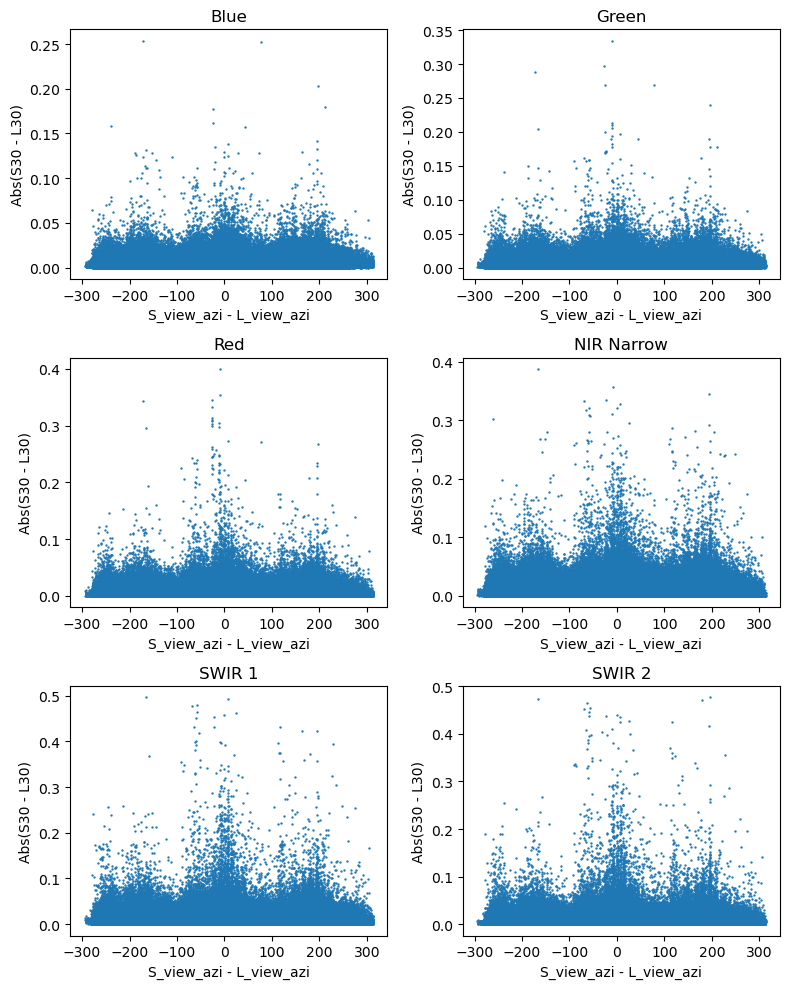

In [33]:
# import seaborn as sns
sample_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'
toa_mask_dir = os.path.join(sample_dir, "TOA_outlier_mask.npy")
toa_mask = np.load(toa_mask_dir).astype(bool)
snow_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_snow_mask.npy"
snow_mask = np.load(snow_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask))
water_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_water_mask.npy"
water_mask = np.load(water_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask * water_mask))
comb_mask = toa_mask * snow_mask * water_mask
n_row = 3
n_col = 2
sample_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\Intermediate\All_samples"
fig, axs = plt.subplots(n_row, n_col, figsize=(8, 10))
plt_banddiff_vs_ang(fig, axs, sample_dir, comb_mask, "Post Bandpass")
plt.savefig(os.path.join(sample_dir, 'PostBandpass_WaterFree_ang_SL.png'), dpi=400)

In [12]:
def plt_banddiff_vs_fb(fig, axs, sample_dir, sample_mask, res):
    sub_pop = 0.01
    marker_size = 0.5
    for i, b in enumerate(HLS_L8):
        l_path = os.path.join(sample_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{b}.npy")
        l_arr = sr_scale * np.load(l_path)[sample_mask]
        s_path = os.path.join(sample_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{L8_2_S2[b]}.npy")
        s_arr = sr_scale * np.load(s_path)[sample_mask]
        diff_arr = np.abs(l_arr - s_arr)
        #  azimuth diff
        va_path = os.path.join(r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_L30_view_azimuth.npy")
        ang_l = 0.01 * np.load(va_path)[sample_mask]
        sa_path = os.path.join(r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_S30_view_azimuth.npy")
        ang_s = 0.01 * np.load(sa_path)[sample_mask]
        # if i== 0:
        #     # print("Total number of samples: ", l_arr.shape)
        #     sample_idx = np.random.rand(l_arr.shape[0]) < sub_pop
        #     # print("Plot number of samples: ", np.sum(sample_idx))
        # diff_arr = diff_arr[sample_idx]
        # ang_l = ang_l[sample_idx]
        # ang_s = ang_s[sample_idx]
        ang_l[ang_l < 175] = 0
        ang_l[ang_l >= 175] = 1
        ang_s[ang_s < 175] = 0
        ang_s[ang_s >= 175] = 1
        ang_comb = ang_l * 10 + ang_s
        
        # max_val = max(np.max(l_arr), np.max(s_arr))
        # mse = np.square(np.subtract(l_arr, s_arr)).mean()
        # rmse = math.sqrt(mse)
        sns.boxplot(ax=axs[i//n_col, i%n_col], x=ang_comb, y=diff_arr, showfliers = False)
        # axs[i//n_col, i%n_col].scatter(ang_arr, diff_arr, s=marker_size)#
        # axs[i//n_col, i%n_col].scatter(l_arr, s_arr, c=kde_arr, s=marker_size)#
        # axs[i//n_col, i%n_col].annotate(f"RMSD = {np.round(rmse, 4)}", xy=(max_val * 0.1, max_val * 0.9))
        axs[i//n_col, i%n_col].set_title(L8_bandname[b])
        # axs[i//n_col, i%n_col].set_xlim((0, max_val))
        # axs[i//n_col, i%n_col].set_ylim((0, max_val))
        # axs[i//n_col, i%n_col].plot([0, max_val], [0, max_val], 'k--', alpha=0.3)

    for ax in axs.flat:
        ax.set(xlabel='F(1)B(0)', ylabel='Abs(S30 - L30)')

#     # fig.delaxes(axs[n_row-1][n_col-1])
#     fig.suptitle(res, fontsize=30)
    plt.tight_layout()

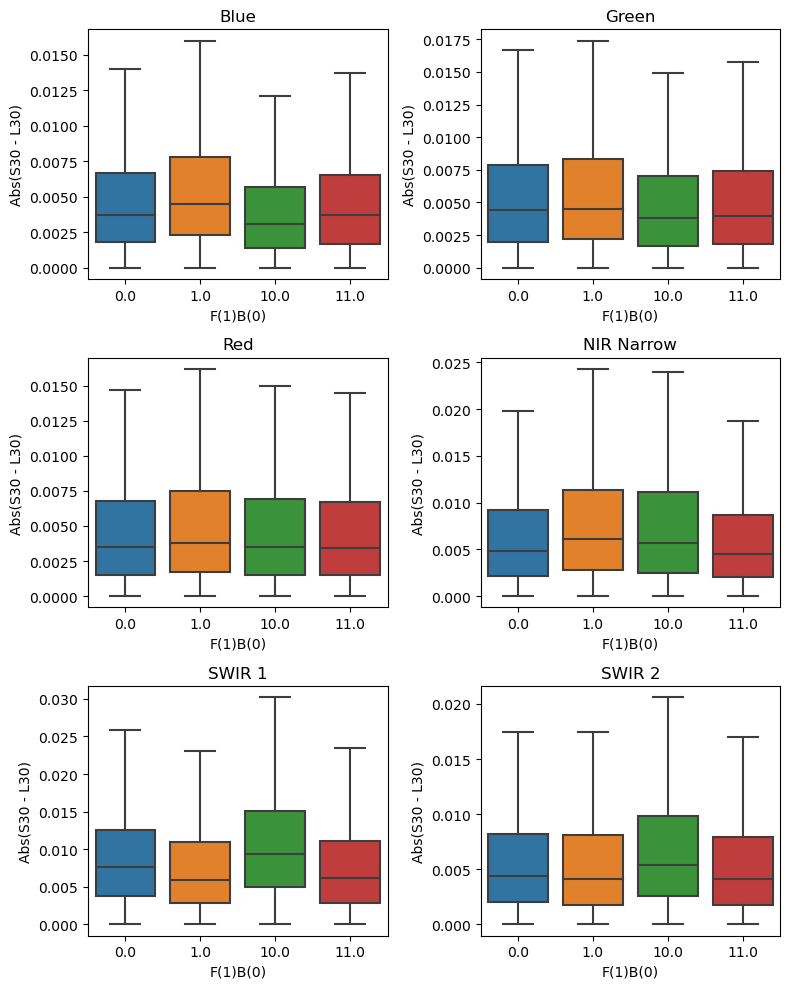

In [35]:
import seaborn as sns
sample_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'
toa_mask_dir = os.path.join(sample_dir, "TOA_outlier_mask.npy")
toa_mask = np.load(toa_mask_dir).astype(bool)
snow_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_snow_mask.npy"
snow_mask = np.load(snow_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask))
water_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_water_mask.npy"
water_mask = np.load(water_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask * water_mask))
comb_mask = toa_mask * snow_mask * water_mask
n_row = 3
n_col = 2
sample_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\Intermediate\All_samples"
fig, axs = plt.subplots(n_row, n_col, figsize=(8, 10))
plt_banddiff_vs_fb(fig, axs, sample_dir, comb_mask, "Post Bandpass")
# plt.savefig(os.path.join(sample_dir, 'PostBandpass_WaterFree_ang_SL.png'), dpi=400)

C:\Users\qzhou2\AppData\Local\Temp\1\ipykernel_4056\2461609616.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  toa_mad_g = toa_df.groupby('Ang').apply(mad)
C:\Users\qzhou2\AppData\Local\Temp\1\ipykernel_4056\2461609616.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ac_mad_g = ac_df.groupby('Ang').apply(mad)
C:\Users\qzhou2\AppData\Local\Temp\1\ipykernel_4056\2461609616.py:61: DeprecationWarning: 

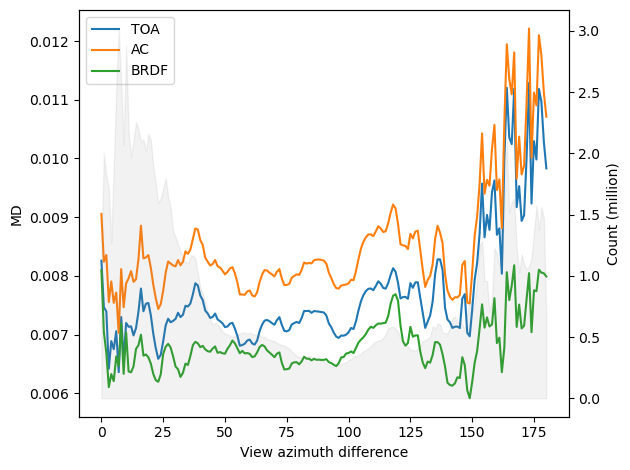

In [15]:
# MAD group by angles: is increasing inconsistency after AC because of SZA?
def mad(g):
    return pd.Series(dict(mad = np.mean(np.abs(g['L30'] - g['S30']))))
    # return np.mean(np.abs(g['L30'] - g['S30']))

toa_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'
# toa_mask_dir = os.path.join(toa_dir, "TOA_outlier_mask.npy")
# toa_mask = np.load(toa_mask_dir).astype(bool)
snow_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_snow_mask.npy"
snow_mask = np.load(snow_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask))
water_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_water_mask.npy"
water_mask = np.load(water_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask * water_mask))
tile_ex = [('11SPV', 2021285), ('55HEU', 2021009), ('55JGH', 2022012), 
              ('55JGH', 2022172), ('55JGH', 2022332), ('55JHM', 2021137),
             ('55JHM', 2021217)]
tile_mask = np.zeros_like(snow_mask, dtype=bool)
for t in tile_ex:
    tile_mask = tile_mask | ((date_arr == t[1]) * (tile_list == t[0]))
# comb_mask = snow_mask * water_mask #toa_mask * 
comb_mask = snow_mask * water_mask * ~tile_mask #toa_mask * 

f_ang = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_L30_view_azimuth.npy'
ang_l_arr = np.load(f_ang)[comb_mask] * 0.01
# ang_l_arr = ang_l_arr.astype(int)
f_ang = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_S30_view_azimuth.npy'
ang_s_arr = np.load(f_ang)[comb_mask] * 0.01
# ang_s_arr = ang_s_arr.astype(int)
# zenith diff
# ang_arr = np.maximum(ang_l_arr, ang_s_arr) 
# azimuth diff
ang_arr = np.abs(ang_l_arr - ang_s_arr)
ang_arr[ang_arr>180] = 360 - ang_arr[ang_arr>180]
ang_arr = np.round(ang_arr)
_, ang_cnt = np.unique(ang_arr, return_counts=True)
# print(np.unique(ang_arr, return_counts=True))

b = 'B07'
inter_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\Intermediate\All_samples'
toa_l_path = os.path.join(toa_dir, f"Merged_filtered_samp_L30_{b}.npy")
toa_l_arr = sr_scale * np.load(toa_l_path)[comb_mask]
toa_s_path = os.path.join(toa_dir, f"Merged_filtered_samp_S30_{L8_2_S2[b]}.npy")
toa_s_arr = sr_scale * np.load(toa_s_path)[comb_mask]
ac_l_path = os.path.join(inter_dir, f"Merged_filtered_samp_L30_sr_{b}.npy")
ac_l_arr = sr_scale * np.load(ac_l_path)[comb_mask]
ac_s_path = os.path.join(inter_dir, f"Merged_filtered_samp_S30_sr_{L8_2_S2[b]}.npy")
ac_s_arr = sr_scale * np.load(ac_s_path)[comb_mask]
brdf_l_path = os.path.join(inter_dir, f"Merged_filtered_samp_L30_sr_nbar_{b}.npy")
brdf_l_arr = sr_scale * np.load(brdf_l_path)[comb_mask]
brdf_s_path = os.path.join(inter_dir, f"Merged_filtered_samp_S30_sr_nbar_{L8_2_S2[b]}.npy")
brdf_s_arr = sr_scale * np.load(brdf_s_path)[comb_mask]
bp_s_path = os.path.join(inter_dir, f"Merged_filtered_samp_S30_sr_nbar_{L8_2_S2[b]}.npy")
bp_s_arr = sr_scale * np.load(brdf_s_path)[comb_mask]

toa_df = pd.DataFrame({'Ang': ang_arr, 'L30': toa_l_arr, 'S30': toa_s_arr})
toa_mad_g = toa_df.groupby('Ang').apply(mad)
ac_df = pd.DataFrame({'Ang': ang_arr, 'L30': ac_l_arr, 'S30': ac_s_arr})
ac_mad_g = ac_df.groupby('Ang').apply(mad)
brdf_df = pd.DataFrame({'Ang': ang_arr, 'L30': brdf_l_arr, 'S30': brdf_s_arr})
brdf_mad_g = brdf_df.groupby('Ang').apply(mad)
bp_df = pd.DataFrame({'Ang': ang_arr, 'L30': brdf_l_arr, 'S30': bp_s_arr})
bp_mad_g = bp_df.groupby('Ang').apply(mad)

mad_g = pd.DataFrame({'Ang': toa_mad_g.index, 
                      'Count': ang_cnt / 1000000.0,
                      'TOA_MAD': toa_mad_g['mad'], 
                      'AC_MAD': ac_mad_g['mad'],
                     'BRDF_MAD': brdf_mad_g['mad'],
                     'Bandpass_MAD': bp_mad_g['mad']})
mad_g.set_index('Ang')
# mad_g[['TOA_MAD', 'AC_MAD', 'BRDF_MAD']].plot.line()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.fill_between(mad_g['Ang'], mad_g['Count'], label='Count (million)', color='grey', alpha=0.1)
ax2.set_ylabel('Count (million)')
ax1.plot(mad_g['Ang'], mad_g['TOA_MAD'], label='TOA')
ax1.plot(mad_g['Ang'], mad_g['AC_MAD'], label='AC')
ax1.plot(mad_g['Ang'], mad_g['BRDF_MAD'], label='BRDF')
ax1.set_xlabel('View azimuth difference')
ax1.set_ylabel('MD')
ax1.legend()
plt.tight_layout()
plt.savefig(os.path.join(inter_dir, f"MAD_by_angle_{b}.png"), dpi=400)

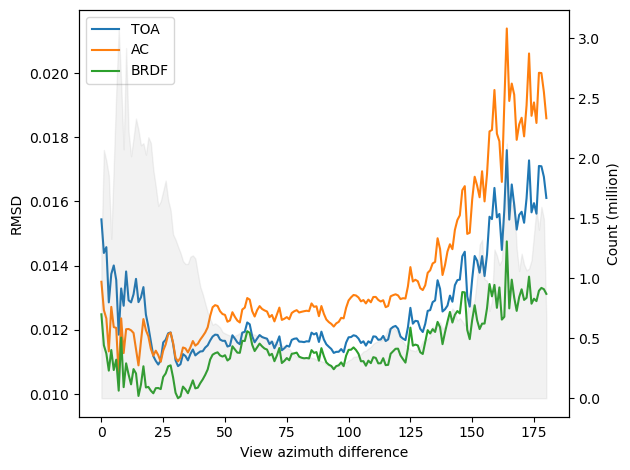

In [16]:
# RMSD group by angles: is increasing inconsistency after AC because of SZA?
def rmsd(g):
    # msd = np.square(np.subtract(l_arr, s_arr)).mean()
    # rmsd = math.sqrt(msd)
    return pd.Series(dict(rmsd = math.sqrt(np.square(g['L30'] - g['S30']).mean())))

toa_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'
# toa_mask_dir = os.path.join(toa_dir, "TOA_outlier_mask.npy")
# toa_mask = np.load(toa_mask_dir).astype(bool)
snow_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_snow_mask.npy"
snow_mask = np.load(snow_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask))
water_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_water_mask.npy"
water_mask = np.load(water_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask * water_mask))
tile_ex = [('11SPV', 2021285), ('55HEU', 2021009), ('55JGH', 2022012), 
              ('55JGH', 2022172), ('55JGH', 2022332), ('55JHM', 2021137),
             ('55JHM', 2021217)]
tile_mask = np.zeros_like(snow_mask, dtype=bool)
for t in tile_ex:
    tile_mask = tile_mask | ((date_arr == t[1]) * (tile_list == t[0]))
# comb_mask = snow_mask * water_mask #toa_mask * 
comb_mask = snow_mask * water_mask * ~tile_mask #toa_mask * 

f_ang = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_L30_view_azimuth.npy'
ang_l_arr = np.load(f_ang)[comb_mask] * 0.01
# ang_l_arr = ang_l_arr.astype(int)
f_ang = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_S30_view_azimuth.npy'
ang_s_arr = np.load(f_ang)[comb_mask] * 0.01
# ang_s_arr = ang_s_arr.astype(int)
# zenith diff
# ang_arr = np.maximum(ang_l_arr, ang_s_arr) 
# azimuth diff
ang_arr = np.abs(ang_l_arr - ang_s_arr)
ang_arr[ang_arr>180] = 360 - ang_arr[ang_arr>180]
ang_arr = np.round(ang_arr)
_, ang_cnt = np.unique(ang_arr, return_counts=True)
# print(np.unique(ang_arr, return_counts=True))

b = 'B05'
inter_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\Intermediate\All_samples'
toa_l_path = os.path.join(toa_dir, f"Merged_filtered_samp_L30_{b}.npy")
toa_l_arr = sr_scale * np.load(toa_l_path)[comb_mask]
toa_s_path = os.path.join(toa_dir, f"Merged_filtered_samp_S30_{L8_2_S2[b]}.npy")
toa_s_arr = sr_scale * np.load(toa_s_path)[comb_mask]
ac_l_path = os.path.join(inter_dir, f"Merged_filtered_samp_L30_sr_{b}.npy")
ac_l_arr = sr_scale * np.load(ac_l_path)[comb_mask]
ac_s_path = os.path.join(inter_dir, f"Merged_filtered_samp_S30_sr_{L8_2_S2[b]}.npy")
ac_s_arr = sr_scale * np.load(ac_s_path)[comb_mask]
brdf_l_path = os.path.join(inter_dir, f"Merged_filtered_samp_L30_sr_nbar_{b}.npy")
brdf_l_arr = sr_scale * np.load(brdf_l_path)[comb_mask]
brdf_s_path = os.path.join(inter_dir, f"Merged_filtered_samp_S30_sr_nbar_{L8_2_S2[b]}.npy")
brdf_s_arr = sr_scale * np.load(brdf_s_path)[comb_mask]
bp_s_path = os.path.join(inter_dir, f"Merged_filtered_samp_S30_sr_nbar_{L8_2_S2[b]}.npy")
bp_s_arr = sr_scale * np.load(brdf_s_path)[comb_mask]

toa_df = pd.DataFrame({'Ang': ang_arr, 'L30': toa_l_arr, 'S30': toa_s_arr})
toa_rmsd_g = toa_df.groupby('Ang').apply(rmsd)
ac_df = pd.DataFrame({'Ang': ang_arr, 'L30': ac_l_arr, 'S30': ac_s_arr})
ac_rmsd_g = ac_df.groupby('Ang').apply(rmsd)
brdf_df = pd.DataFrame({'Ang': ang_arr, 'L30': brdf_l_arr, 'S30': brdf_s_arr})
brdf_rmsd_g = brdf_df.groupby('Ang').apply(rmsd)
bp_df = pd.DataFrame({'Ang': ang_arr, 'L30': brdf_l_arr, 'S30': bp_s_arr})
bp_rmsd_g = bp_df.groupby('Ang').apply(rmsd)

rmsd_g = pd.DataFrame({'Ang': toa_rmsd_g.index, 
                      'Count': ang_cnt / 1000000.0,
                      'TOA_RMSD': toa_rmsd_g['rmsd'], 
                      'AC_RMSD': ac_rmsd_g['rmsd'],
                     'BRDF_RMSD': brdf_rmsd_g['rmsd'],
                     'Bandpass_RMSD': bp_rmsd_g['rmsd']})
rmsd_g.set_index('Ang')
# mad_g[['TOA_MAD', 'AC_MAD', 'BRDF_MAD']].plot.line()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.fill_between(rmsd_g['Ang'], rmsd_g['Count'], label='Count (million)', color='grey', alpha=0.1)
ax2.set_ylabel('Count (million)')
ax1.plot(rmsd_g['Ang'], rmsd_g['TOA_RMSD'], label='TOA')
ax1.plot(rmsd_g['Ang'], rmsd_g['AC_RMSD'], label='AC')
ax1.plot(rmsd_g['Ang'], rmsd_g['BRDF_RMSD'], label='BRDF')
ax1.set_xlabel('View azimuth difference')
ax1.set_ylabel('RMSD')
ax1.legend()
plt.tight_layout()
plt.savefig(os.path.join(inter_dir, f"RMSD_by_angle_{b}.png"), dpi=400)

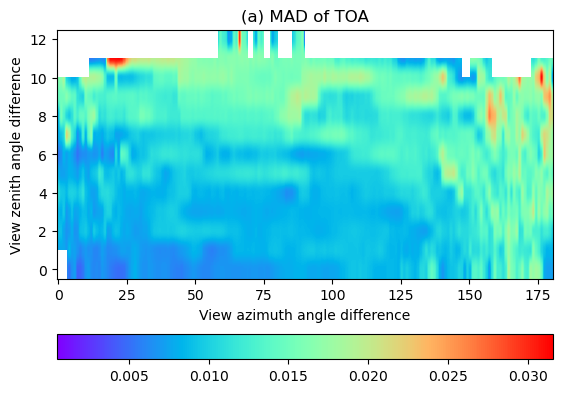

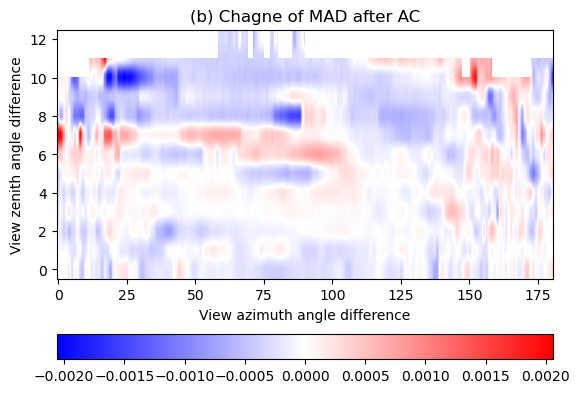

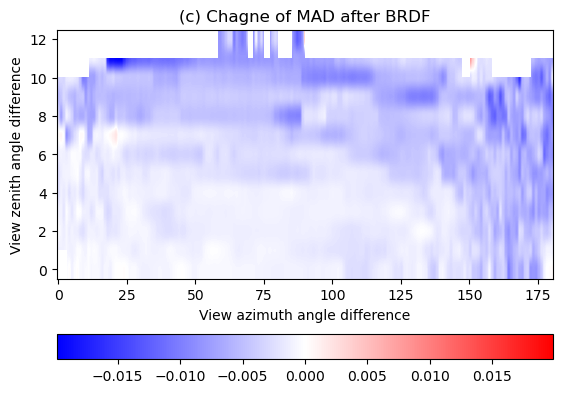

In [26]:
# MAD group by angles: is increasing inconsistency after AC because of SZA?
def mad(g):
    return pd.Series(dict(mad = np.mean(np.abs(g['L30'] - g['S30']))))
    # return np.mean(np.abs(g['L30'] - g['S30']))

def plot_contour(x,y,z,resolution = 50,contour_method='linear'):
    resolution = str(resolution)+'j'
    X,Y = np.mgrid[min(x):max(x):complex(resolution),   min(y):max(y):complex(resolution)]
    points = [[a,b] for a,b in zip(x,y)]
    Z = griddata(points, z, (X, Y), method=contour_method)
    return X,Y,Z
    
toa_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'
# toa_mask_dir = os.path.join(toa_dir, "TOA_outlier_mask.npy")
# toa_mask = np.load(toa_mask_dir).astype(bool)
snow_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_snow_mask.npy"
snow_mask = np.load(snow_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask))
water_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_water_mask.npy"
water_mask = np.load(water_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask * water_mask))
comb_mask = snow_mask * water_mask # toa_mask * 

f_ang = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_L30_view_azimuth.npy'
ang_l_arr = np.load(f_ang)[comb_mask] * 0.01
# ang_l_arr = ang_l_arr.astype(int)
f_ang = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_S30_view_azimuth.npy'
ang_s_arr = np.load(f_ang)[comb_mask] * 0.01
# ang_s_arr = ang_s_arr.astype(int)
# zenith diff
# ang_arr = np.maximum(ang_l_arr, ang_s_arr) 
# azimuth diff
ang_arr_va = np.abs(ang_l_arr - ang_s_arr)
ang_arr_va[ang_arr_va>180] = 360 - ang_arr_va[ang_arr_va>180]
ang_arr_va = np.round(ang_arr_va).astype(int)
_, ang_cnt = np.unique(ang_arr_va, return_counts=True)
# print(np.unique(ang_arr, return_counts=True))

f_ang = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_L30_view_zenith.npy'
ang_l_arr = np.load(f_ang)[comb_mask] * 0.01
# ang_l_arr = ang_l_arr.astype(int)
f_ang = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_S30_view_zenith.npy'
ang_s_arr = np.load(f_ang)[comb_mask] * 0.01
# ang_s_arr = ang_s_arr.astype(int)
# zenith diff
# ang_arr_vz = np.maximum(ang_l_arr, ang_s_arr) 
# ang_arr_vz = np.minimum(ang_l_arr, ang_s_arr) 
# ang_arr_vz = (ang_l_arr + ang_s_arr) / 2.0
ang_arr_vz = np.abs(ang_l_arr - ang_s_arr)
ang_arr_vz = np.round(ang_arr_vz).astype(int)
# _, ang_cnt = np.unique(ang_arr, return_counts=True)
# print(np.unique(ang_arr, return_counts=True))

b = 'B05'
aspect_ratio = 0.5
clr_map = 'rainbow'
inter_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\Intermediate\All_samples'
toa_l_path = os.path.join(toa_dir, f"Merged_filtered_samp_L30_{b}.npy")
toa_l_arr = sr_scale * np.load(toa_l_path)[comb_mask]
toa_s_path = os.path.join(toa_dir, f"Merged_filtered_samp_S30_{L8_2_S2[b]}.npy")
toa_s_arr = sr_scale * np.load(toa_s_path)[comb_mask]
ac_l_path = os.path.join(inter_dir, f"Merged_filtered_samp_L30_sr_{b}.npy")
ac_l_arr = sr_scale * np.load(ac_l_path)[comb_mask]
ac_s_path = os.path.join(inter_dir, f"Merged_filtered_samp_S30_sr_{L8_2_S2[b]}.npy")
ac_s_arr = sr_scale * np.load(ac_s_path)[comb_mask]
brdf_l_path = os.path.join(inter_dir, f"Merged_filtered_samp_L30_sr_nbar_{b}.npy")
brdf_l_arr = sr_scale * np.load(brdf_l_path)[comb_mask]
brdf_s_path = os.path.join(inter_dir, f"Merged_filtered_samp_S30_sr_nbar_{L8_2_S2[b]}.npy")
brdf_s_arr = sr_scale * np.load(brdf_s_path)[comb_mask]
bp_s_path = os.path.join(inter_dir, f"Merged_filtered_samp_S30_sr_nbar_{L8_2_S2[b]}.npy")
bp_s_arr = sr_scale * np.load(brdf_s_path)[comb_mask]

toa_df = pd.DataFrame({'Ang_va': ang_arr_va, 'Ang_vz': ang_arr_vz, 'L30': toa_l_arr, 'S30': toa_s_arr})
toa_mad_g = toa_df.groupby(['Ang_va', 'Ang_vz']).apply(mad)
ac_df = pd.DataFrame({'Ang_va': ang_arr_va, 'Ang_vz': ang_arr_vz, 'L30': ac_l_arr, 'S30': ac_s_arr})
ac_mad_g = ac_df.groupby(['Ang_va', 'Ang_vz']).apply(mad)
brdf_df = pd.DataFrame({'Ang_va': ang_arr_va, 'Ang_vz': ang_arr_vz, 'L30': brdf_l_arr, 'S30': brdf_s_arr})
brdf_mad_g = brdf_df.groupby(['Ang_va', 'Ang_vz']).apply(mad)
bp_df = pd.DataFrame({'Ang_va': ang_arr_va, 'Ang_vz': ang_arr_vz, 'L30': brdf_l_arr, 'S30': bp_s_arr})
bp_mad_g = bp_df.groupby(['Ang_va', 'Ang_vz']).apply(mad)

# mad_g = pd.DataFrame({'Ang_va': toa_mad_g.index, 
#                       'Count': ang_cnt / 1000000.0,
#                       'TOA_MAD': toa_mad_g['mad'], 
#                       'AC_MAD': ac_mad_g['mad'],
#                      'BRDF_MAD': brdf_mad_g['mad'],
#                      'Bandpass_MAD': bp_mad_g['mad']})
# mad_g.set_index('Ang_va')
# mad_g[['TOA_MAD', 'AC_MAD', 'BRDF_MAD']].plot.line()
# print(toa_mad_g.head())

toa_mad_g = toa_mad_g.reset_index()
mesh_arr = np.zeros((np.max(toa_mad_g['Ang_vz'])+1, np.max(toa_mad_g['Ang_va'])+1))
mesh_arr[:] = np.nan
mesh_arr[toa_mad_g['Ang_vz'], toa_mad_g['Ang_va']] = toa_mad_g['mad']
# mesh_arr[mesh_arr == 0] = np.nan
vmin = np.min([np.min(toa_mad_g['mad']), np.min(ac_mad_g['mad']), np.min(brdf_mad_g['mad']), np.min(bp_mad_g['mad'])])
vmax = np.max([np.max(toa_mad_g['mad']), np.max(ac_mad_g['mad']), np.max(brdf_mad_g['mad']), np.max(bp_mad_g['mad'])])
im = plt.imshow(mesh_arr, origin='lower', vmin=vmin, vmax=vmax, cmap=clr_map, aspect=int(aspect_ratio * np.max(toa_mad_g['Ang_va'])/np.max(toa_mad_g['Ang_vz']))) # 
plt.title("(a) MAD of TOA")
plt.ylabel('View zenith angle difference')
plt.xlabel('View azimuth angle difference')
plt.colorbar(orientation="horizontal")
plt.show()

ac_mad_g = ac_mad_g.reset_index()
mesh_arr = np.zeros((np.max(ac_mad_g['Ang_vz'])+1, np.max(ac_mad_g['Ang_va'])+1))
mesh_arr[:] = np.nan
mesh_arr[ac_mad_g['Ang_vz'], ac_mad_g['Ang_va']] = ac_mad_g['mad'] - toa_mad_g['mad']
vmin = -1 * np.max(np.abs(ac_mad_g['mad'] - toa_mad_g['mad']))
vmax = np.max(np.abs(ac_mad_g['mad'] - toa_mad_g['mad']))
im = plt.imshow(mesh_arr, origin='lower', vmin=vmin, vmax=vmax, cmap='bwr', aspect=int(aspect_ratio * np.max(toa_mad_g['Ang_va'])/np.max(toa_mad_g['Ang_vz'])))#
plt.title("(b) Chagne of MAD after AC")
plt.ylabel('View zenith angle difference')
plt.xlabel('View azimuth angle difference')
plt.colorbar(orientation="horizontal")
plt.show()

brdf_mad_g = brdf_mad_g.reset_index()
mesh_arr = np.zeros((np.max(brdf_mad_g['Ang_vz'])+1, np.max(brdf_mad_g['Ang_va'])+1))
mesh_arr[:] = np.nan
mesh_arr[brdf_mad_g['Ang_vz'], brdf_mad_g['Ang_va']] = brdf_mad_g['mad'] - toa_mad_g['mad']
vmin = -1 * np.max(np.abs(brdf_mad_g['mad'] - toa_mad_g['mad']))
vmax = np.max(np.abs(brdf_mad_g['mad'] - toa_mad_g['mad']))
im = plt.imshow(mesh_arr, origin='lower', vmin=vmin, vmax=vmax, cmap='bwr', aspect=int(aspect_ratio * np.max(toa_mad_g['Ang_va'])/np.max(toa_mad_g['Ang_vz']))) #
plt.title("(c) Chagne of MAD after BRDF")
plt.ylabel('View zenith angle difference')
plt.xlabel('View azimuth angle difference')
plt.colorbar(orientation="horizontal")
plt.show()

# Vegetation observation

In [11]:
# NDVI = (NIR - R) / (NIR + R)
def ndvi(red_arr, nir_arr):
    arr = (nir_arr - red_arr) / (nir_arr + red_arr)
    arr[(nir_arr + red_arr) == 0] = np.nan
    arr[(red_arr < 0) | (red_arr > 1)] = np.nan
    arr[(nir_arr < 0) | (nir_arr > 1)] = np.nan
    return arr

# EVI = 2.5 * ((NIR - R) / (NIR + 6 * R – 7.5 * B + 1))
def evi(blue_arr, red_arr, nir_arr):
    arr = 2.5 * ((nir_arr - red_arr) / (nir_arr + 6 * red_arr - 7.5 * blue_arr + 1))
    arr[(blue_arr < 0) | (blue_arr > 1)] = np.nan
    arr[(red_arr < 0) | (red_arr > 1)] = np.nan
    arr[(nir_arr < 0) | (nir_arr > 1)] = np.nan
    return arr

# SAVI = ((NIR - R) / (NIR + R + 0.5)) * (1.5)
def savi(red_arr, nir_arr):
    arr = ((nir_arr - red_arr) / (nir_arr + red_arr + 0.5)) * 1.5
    arr[(red_arr < 0) | (red_arr > 1)] = np.nan
    arr[(nir_arr < 0) | (nir_arr > 1)] = np.nan
    return arr

# MSAVI = (2 * NIR + 1 – sqrt ((2 * NIR + 1)^2 – 8 * (NIR - R))) / 2
def msavi(red_arr, nir_arr):
    arr = (2 * nir_arr + 1 - np.sqrt(np.square(2 * nir_arr + 1) - 8 * (nir_arr - red_arr))) / 2
    arr[(red_arr < 0) | (red_arr > 1)] = np.nan
    arr[(nir_arr < 0) | (nir_arr > 1)] = np.nan
    return arr

# NDMI = (NIR - SWIR1) / (NIR + SWIR1)
def ndmi(nir_arr, swir1_arr):
    arr = (nir_arr - swir1_arr) / (nir_arr + swir1_arr)
    arr[(nir_arr < 0) | (nir_arr > 1)] = np.nan
    arr[(swir1_arr < 0) | (swir1_arr > 1)] = np.nan
    arr[(nir_arr + swir1_arr) == 0] = np.nan
    return arr

# NBR = (NIR - SWIR2) / (NIR + SWIR2)
def nbr(nir_arr, swir2_arr):
    arr = (nir_arr - swir2_arr) / (nir_arr + swir2_arr)
    arr[(nir_arr < 0) | (nir_arr > 1)] = np.nan
    arr[(swir2_arr < 0) | (swir2_arr > 1)] = np.nan
    arr[(nir_arr + swir2_arr) == 0] = np.nan
    return arr

# NBR2 = (SWIR1 – SWIR2) / (SWIR1 + SWIR2)
def nbr2(swir1_arr, swir2_arr):
    arr = (swir1_arr - swir2_arr) / (swir1_arr + swir2_arr)
    arr[(swir1_arr < 0) | (swir1_arr > 1)] = np.nan
    arr[(swir2_arr < 0) | (swir2_arr > 1)] = np.nan
    arr[(swir1_arr + swir2_arr) == 0] = np.nan
    return arr

# # TVI = sqrt(NDVI + 0.5)   - Transformed Vegetation Index
# def tvi2(nir_arr, red_arr):
#     return np.sqrt((nir_arr - red_arr) / (nir_arr + red_arr) + 0.5)

# TVI = (120*(B5-B3)-200*(B4-B3))/2  - Triangular Vegetation Index
def tvi(green_arr, red_arr, nir_arr):
    arr = (120*(nir_arr-green_arr)-200*(red_arr-green_arr))/2
    arr[(green_arr < 0) | (green_arr > 1)] = np.nan
    arr[(red_arr < 0) | (red_arr > 1)] = np.nan
    arr[(nir_arr < 0) | (nir_arr > 1)] = np.nan
    return arr

# NDWI = (GREEN - NIR) / (GREEN + NIR)
def ndwi(green_arr, nir_arr):
    arr = (green_arr - nir_arr) / (green_arr + nir_arr)
    arr[(green_arr < 0) | (green_arr > 1)] = np.nan
    arr[(nir_arr < 0) | (nir_arr > 1)] = np.nan
    arr[(green_arr + nir_arr) == 0] = np.nan
    return arr


def cal_vi(work_dir, vi_name, res, sample_mask):
    ## Calculate vegetation indexes for the final results of intermediate samples
    if vi_name == 'NDVI':
        red_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['Red']}.npy"))[sample_mask]#[sample_idx]
        nir_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        l_arr = ndvi(red_l, nir_l)
        red_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['Red']}.npy"))[sample_mask]#[sample_idx]
        nir_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        s_arr = ndvi(red_s, nir_s)
    elif vi_name == 'EVI':
        blue_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['Blue']}.npy"))[sample_mask]#[sample_idx]
        red_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['Red']}.npy"))[sample_mask]#[sample_idx]
        nir_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        l_arr = evi(blue_l, red_l, nir_l)
        blue_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['Blue']}.npy"))[sample_mask]#[sample_idx]
        red_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['Red']}.npy"))[sample_mask]#[sample_idx]
        nir_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        s_arr = evi(blue_s, red_s, nir_s)
    elif vi_name == 'SAVI':
        red_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['Red']}.npy"))[sample_mask]#[sample_idx]
        nir_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        l_arr = savi(red_l, nir_l)
        red_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['Red']}.npy"))[sample_mask]#[sample_idx]
        nir_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        s_arr = savi(red_s, nir_s)
    elif vi_name == 'MSAVI':
        red_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['Red']}.npy"))[sample_mask]#[sample_idx]
        nir_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        l_arr = msavi(red_l, nir_l)
        red_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['Red']}.npy"))[sample_mask]#[sample_idx]
        nir_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        s_arr = msavi(red_s, nir_s)
    elif vi_name == 'NDMI':
        nir_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        swir1_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['SWIR1']}.npy"))[sample_mask]#[sample_idx]
        l_arr = ndmi(nir_l, swir1_l)
        nir_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        swir1_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['SWIR1']}.npy"))[sample_mask]#[sample_idx]
        s_arr = ndmi(nir_s, swir1_s)
    elif vi_name == 'NBR':
        nir_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        swir2_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['SWIR2']}.npy"))[sample_mask]#[sample_idx]
        l_arr = nbr(nir_l, swir2_l)
        nir_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        swir2_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['SWIR2']}.npy"))[sample_mask]#[sample_idx]
        s_arr = nbr(nir_s, swir2_s)
    elif vi_name == 'NBR2':
        swir1_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['SWIR1']}.npy"))[sample_mask]#[sample_idx]
        swir2_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['SWIR2']}.npy"))[sample_mask]#[sample_idx]
        l_arr = nbr2(swir1_l, swir2_l)
        swir1_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['SWIR1']}.npy"))[sample_mask]#[sample_idx]
        swir2_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['SWIR2']}.npy"))[sample_mask]#[sample_idx]
        s_arr = nbr2(swir1_s, swir2_s)
    elif vi_name == 'TVI':
        green_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['Green']}.npy"))[sample_mask]#[sample_idx]
        red_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['Red']}.npy"))[sample_mask]#[sample_idx]
        nir_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        l_arr = tvi(green_l, red_l, nir_l)
        green_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['Green']}.npy"))[sample_mask]#[sample_idx]
        red_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['Red']}.npy"))[sample_mask]#[sample_idx]
        nir_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        s_arr = tvi(green_s, red_s, nir_s)
    elif  vi_name == 'NDWI':
        green_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['Green']}.npy"))[sample_mask]#[sample_idx]
        nir_l = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_L30{res_id[res][0]}_{L8_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        l_arr = ndwi(green_l, nir_l)
        green_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['Green']}.npy"))[sample_mask]#[sample_idx]
        nir_s = sr_scale * np.load(os.path.join(work_dir, f"Merged_filtered_samp_S30{res_id[res][1]}_{S2_name2index['NIR']}.npy"))[sample_mask]#[sample_idx]
        s_arr = ndwi(green_s, nir_s)
    else:
        print('VI not implemented.')
        return None, None
    return l_arr, s_arr

In [12]:
vi_range = {'NDVI': [-1, 1], 'EVI': [-1, 1], 'SAVI': [-1, 1], 'MSAVI': [-1, 1],
           'NDMI': [-1, 1], 'NDWI': [-1, 1], 'NBR': [-1, 1], 'NBR2': [-1, 1], 'TVI': [-1, 25], 'TVI2': [0, 1.2]}
def plt_vi_scatter(fig, axs, sample_dir, sample_mask, ind_list, reg_med='OLS', err_idx='rmsd'):
    sub_pop = 0.1
    marker_size = 0.5
    for i, b in enumerate(ind_list):
        # l_path = os.path.join(sample_dir, f"Merged_filtered_samp_L30_sr_nbar_NDVI.npy")
        # l_ndvi = np.load(l_path)[sample_mask]
        # s_path = os.path.join(sample_dir, f"Merged_filtered_samp_S30_sr_nbar_bp_NDVI.npy")
        # s_ndvi = np.load(s_path)[sample_mask]
        # mask_ndvi = (l_ndvi > 0.2) * (l_ndvi < 1.0) * (s_ndvi > 0.2) * (s_ndvi < 1.0)
        
        # l_path = os.path.join(sample_dir, f"Merged_filtered_samp_L30_sr_nbar_{b}.npy")
        # l_arr = np.load(l_path)[sample_mask]
        # s_path = os.path.join(sample_dir, f"Merged_filtered_samp_S30_sr_nbar_bp_{b}.npy")
        # s_arr = np.load(s_path)[sample_mask]

        l_arr, s_arr = cal_vi(sample_dir, b, "Post Bandpass", sample_mask) #Post Bandpass
        
        water_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_water_mask.npy"
        water_mask = np.load(water_dir)#.astype(bool)
        # print('sample_mask ', sample_mask.shape, np.sum(sample_mask))
        # print('water_mask ', water_mask.shape, np.sum(water_mask))
        # kde_mask_path = os.path.join(sample_dir, f"Merged_filtered_samp_kde_sr_nbar_bp_{b}_mask.npy")
        # kde_mask_arr = np.load(kde_mask_path)
        # print('kde_mask_arr ', kde_mask_arr.shape, np.sum(kde_mask_arr))
        # print('Processing mask shape: ', sample_mask.shape, mask_ndvi.shape, kde_mask_arr.shape)
        # print('Processing mask sum: ', np.sum(sample_mask), np.sum(mask_ndvi), np.sum(kde_mask_arr))
        # l_arr = l_arr[(kde_mask_arr == 1) * water_mask[sample_mask]]# * mask_ndvi
        # s_arr = s_arr[(kde_mask_arr == 1) * water_mask[sample_mask]]# * mask_ndvi
        l_arr = l_arr[water_mask[sample_mask]]# * mask_ndvi
        s_arr = s_arr[water_mask[sample_mask]]# * mask_ndvi
        # print('VI range: ', np.percentile(l_arr, 1), np.percentile(s_arr, 1), np.percentile(l_arr, 99), np.percentile(s_arr, 99))
        valid_mask = (l_arr>vi_range[b][0]) * (l_arr<vi_range[b][1]) * (s_arr>vi_range[b][0]) * (s_arr<vi_range[b][1])
        l_arr = l_arr[valid_mask]
        s_arr = s_arr[valid_mask]
        # print(b, ' data range: ', np.min(l_arr), np.max(l_arr), np.min(s_arr), np.max(s_arr))
        if err_idx=='rmsd':
            msd = np.square(np.subtract(l_arr, s_arr)).mean()
            rmsd = math.sqrt(msd)
            print('RMSD in terms of L30: ', b, rmsd, rmsd / np.mean(l_arr), rmsd / np.mean(np.abs(l_arr)))
        elif err_idx=='mad':
            mad = np.mean(np.abs(l_arr - s_arr))
            if (b != 'NDMI') and (b != 'NBR'):
                print('MAD in terms of L30: ', b, mad, mad / np.mean(l_arr), mad / np.mean(np.abs(l_arr)))
            else:
                print('MAD in terms of L30: ', b, mad, mad / np.mean(l_arr), mad / np.mean(np.abs(l_arr)), mad / np.mean([np.abs(np.mean(l_arr[l_arr < 0])), np.abs(np.mean(l_arr[l_arr > 0]))]))
        else:
            print('err_idx can only be rmsd or mad.')

        if reg_med == 'OLS':
            model = LinearRegression(fit_intercept=False)
            model.fit(l_arr.reshape(-1, 1), s_arr)
            model_slope = model.coef_[0]
            model_inter = model.intercept_
            y_pred = model.predict(l_arr.reshape(-1, 1))
        elif reg_med == 'RMA':
            # return structure: {"slope": float(slope), "intercept": intercept, "r": r,
            # "std_slope": std_slope, "std_intercept": std_intercept,
            # "predict": predict}
            # print('l_arr.shape, s_arr.shape: ', l_arr.shape, s_arr.shape)
            # model_dict = deming_regresion(l_arr, s_arr)
            # print('deming model_dict: ', model_dict)
            # print('deming model_dict val: ', deming_regresion(s_arr, l_arr))
            model_dict = rma_regression(l_arr, s_arr, need_intercept=False)
            print('rma model_dict: ', model_dict)
            print('rma model_dict val: ', rma_regression(s_arr, l_arr, need_intercept=False))
            # print('model_dict val: ', regress2(s_arr, l_arr.reshape(-1, 1), _method_type_2="reduced major axis", _need_intercept=False))
            model_slope = model_dict[0]
            model_inter = model_dict[1]
            y_pred = model_slope * l_arr + model_inter
            
            # y_pred = model_dict['predict']
        else:
            print('reg_med can only be OLS or RMA.')

        r2 = r2_score(s_arr, y_pred)
        
        sample_idx = (np.random.rand(l_arr.shape[0]) < sub_pop)# * (l_arr < 1) * (s_arr < 1)
        l_arr = l_arr[sample_idx]
        s_arr = s_arr[sample_idx]
        # kde_arr = kde_arr[sample_idx]

        max_val = max(np.percentile(l_arr, 99.99), np.percentile(s_arr, 99.99))
        min_val = max(np.percentile(l_arr, 0.01), np.percentile(s_arr, 0.01))
        print(b, max_val, min_val)
        if min_val > 0:
            x_ann = min_val * 1.3
        else:
            x_ann = min_val * 0.7
        # max_val = max(np.max(l_arr), np.max(s_arr))
        # max_val = min(max_val, 1.0)
        # xy = np.vstack([l_arr, s_arr])
        # z = gaussian_kde(xy)(xy)
        
        # axs[i//n_col, i%n_col].scatter(l_arr, s_arr, c=z, s=marker_size)# kde_arr
        counts, xedges, yedges, im = axs[i//n_col, i%n_col].hist2d(l_arr, s_arr, bins=300, range=[[min_val,max_val],[min_val,max_val]], cmin=1, norm=colors.LogNorm(vmin=1,vmax=1e+4), cmap = cm.plasma)
        # print('Max count: ', np.nanmax(counts))
        # axs[i//n_col, i%n_col].scatter(l_arr, z, s=marker_size)# kde_arr
        # axs[i//n_col, i%n_col].annotate(f"RMSD = {np.round(rmse, 3)}", xy=((max_val + min_val) * 0.2, (max_val + min_val) * 0.7))
        # axs[i//n_col, i%n_col].annotate(f"MAD = {np.round(mad, 3)}", xy=(min_val + 0.1, max_val - 0.1))
        axs[i//n_col, i%n_col].set_title(b)
        # if err_idx=='rmsd':
        #     axs[i//n_col, i%n_col].set_title(b + f'\nRMSD = {np.round(rmsd, 3)}')
        # elif err_idx=='mad':
        #     axs[i//n_col, i%n_col].set_title(b + f'\nMD = {np.round(mad, 3)}')
        # else:
        #     print('err_idx can only be rmsd or mad.')

        axs[i//n_col, i%n_col].set_xlim((min_val, max_val))
        axs[i//n_col, i%n_col].set_ylim((min_val, max_val))
        ticks = axs[i//n_col, i%n_col].get_yticks()
        if (ticks[0] < 0) & (ticks[0] < min_val):
            ticks = ticks[1:]
        if ticks[-1] > max_val:
            ticks = ticks[:-1]
        axs[i//n_col, i%n_col].set_xticks(ticks)
        axs[i//n_col, i%n_col].set_yticks(ticks)
        print(axs[i//n_col, i%n_col].get_yticks())
        axs[i//n_col, i%n_col].set_xlabel(f'Landsat {b}')
        axs[i//n_col, i%n_col].set_ylabel(f'Sentinel-2 {b}')
        axs[i//n_col, i%n_col].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
        xseq = np.linspace(min_val, max_val, num=10)
        if err_idx == 'rmsd':
            axs[i//n_col, i%n_col].annotate(f"RMSD = {np.round(rmsd, 4):.4f}", xy=(0.05, 0.8), xycoords='axes  fraction')
        elif err_idx == 'mad':
            axs[i//n_col, i%n_col].annotate(f"MD = {np.round(mad, 4):.4f}", xy=(0.05, 0.8), xycoords='axes  fraction') #xy=(x_ann, max_val * 0.79)
        else:
            print('err_idx can only be rmsd or mad.')
        if reg_med == 'OLS':
            axs[i//n_col, i%n_col].plot(xseq, model.predict(xseq.reshape(-1, 1)), color="r")
        elif reg_med == 'RMA':
            axs[i//n_col, i%n_col].plot(xseq, model_slope * xseq + model_inter, color="r")
        else:
            print('reg_med can only be OLS or RMA.')
        if model_inter >= 0:
            axs[i//n_col, i%n_col].annotate(f"y = {np.round(model_slope, 4)}x", xy=(0.05, 0.95), xycoords='axes  fraction') #+{np.round(model.intercept_, 4)}
        else:
            axs[i//n_col, i%n_col].annotate(f"y = {np.round(model_slope, 4)}x", xy=(0.05, 0.95), xycoords='axes  fraction') #{np.round(model.intercept_, 4)}
        axs[i//n_col, i%n_col].annotate(f"R-squared = {np.round(r2, 4)}", xy=(0.05, 0.87), xycoords='axes  fraction')
        
    # fig.delaxes(axs[n_row-1][n_col-1])
    fig.subplots_adjust(right=0.8, wspace=0.25, hspace=0.3)
    cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    fig.colorbar(im, cax=cbar_ax).set_label('Count')
    # fig.suptitle(b, fontsize=30)
    # plt.tight_layout()

Total number of valid samples pairs:  160253969


C:\Users\qzhou2\AppData\Local\Temp\1\ipykernel_15744\973816350.py:3: RuntimeWarning: divide by zero encountered in divide
  arr = (nir_arr - red_arr) / (nir_arr + red_arr)


MAD in terms of L30:  NDVI 0.017153090171910503 0.039803505033399654 0.03980313807035353
[[0.06474353 0.06484321]
 [0.06484321 0.06559567]]
rma model_dict:  (1.0065593933859578, 0)
[[0.06559567 0.06484321]
 [0.06484321 0.06474353]]
rma model_dict val:  (0.9934833518726671, 0)
NDVI 0.9563212364718892 0.016883940941344343
[0.  0.2 0.4 0.6 0.8]
MAD in terms of L30:  EVI 0.011307804378976003 0.045093909979911154 0.04509345872165528
[[0.02578907 0.02540888]
 [0.02540888 0.02532709]]
rma model_dict:  (0.9910025232462232, 0)
[[0.02532709 0.02540888]
 [0.02540888 0.02578907]]
rma model_dict val:  (1.0090791663418817, 0)
EVI 0.9347021909320554 0.01164685518909247
[0.  0.2 0.4 0.6 0.8]
MAD in terms of L30:  SAVI 0.010359295253971692 0.04086441499131095 0.04086410171517533
[[0.02138135 0.02118884]
 [0.02118884 0.0212304 ]]
rma model_dict:  (0.9964636130178056, 0)
[[0.0212304  0.02118884]
 [0.02118884 0.02138135]]
rma model_dict val:  (1.00354893739821, 0)
SAVI 0.7821245353606399 0.011330546070484

C:\Users\qzhou2\AppData\Local\Temp\1\ipykernel_15744\973816350.py:26: RuntimeWarning: invalid value encountered in sqrt
  arr = (2 * nir_arr + 1 - np.sqrt(np.square(2 * nir_arr + 1) - 8 * (nir_arr - red_arr))) / 2


MAD in terms of L30:  MSAVI 0.01087990919853004 0.04599171653178926 0.045991389150493084
[[0.02303477 0.02279492]
 [0.02279492 0.02283101]]
rma model_dict:  (0.9955673610033648, 0)
[[0.02283101 0.02279492]
 [0.02279492 0.02303477]]
rma model_dict val:  (1.0044523747666534, 0)
MSAVI 0.8797675622155487 0.00980780067693168
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
MAD in terms of L30:  NDMI 0.018033571508807848 0.688503446570484 0.11113602932052315 0.10652205399853354
[[0.03991016 0.03886155]
 [0.03886155 0.0382695 ]]
rma model_dict:  (0.9792299676980176, 0)
[[0.0382695  0.03886155]
 [0.03886155 0.03991016]]
rma model_dict val:  (1.0212105766644466, 0)
NDMI 0.706005867368102 -0.45096937940452686
[-0.4 -0.2  0.   0.2  0.4  0.6]


C:\Users\qzhou2\AppData\Local\Temp\1\ipykernel_15744\973816350.py:41: RuntimeWarning: divide by zero encountered in divide
  arr = (nir_arr - swir2_arr) / (nir_arr + swir2_arr)


MAD in terms of L30:  NBR 0.016258470474420583 0.07689782821198574 0.06402072824423838 0.08034380722416468
[[0.07399486 0.07270842]
 [0.07270842 0.07196047]]
rma model_dict:  (0.9861573342908185, 0)
[[0.07196047 0.07270842]
 [0.07270842 0.07399486]]
rma model_dict val:  (1.0140369748597329, 0)
NBR 0.8800148508660606 -0.4535755028002791
[-0.4 -0.2  0.   0.2  0.4  0.6  0.8]


C:\Users\qzhou2\AppData\Local\Temp\1\ipykernel_15744\973816350.py:49: RuntimeWarning: divide by zero encountered in divide
  arr = (swir1_arr - swir2_arr) / (swir1_arr + swir2_arr)
C:\Users\qzhou2\AppData\Local\Temp\1\ipykernel_15744\973816350.py:49: RuntimeWarning: invalid value encountered in divide
  arr = (swir1_arr - swir2_arr) / (swir1_arr + swir2_arr)


MAD in terms of L30:  NBR2 0.009629672194792096 0.04678836405991998 0.04676773968654903
[[0.01407015 0.01378783]
 [0.01378783 0.01367568]]
rma model_dict:  (0.9858824942336526, 0)
[[0.01367568 0.01378783]
 [0.01378783 0.01407015]]
rma model_dict val:  (1.0143196637012215, 0)
NBR2 0.5267039446864505 -0.05589072043014789
[0.  0.1 0.2 0.3 0.4 0.5]
MAD in terms of L30:  TVI 0.43329630442368716 0.058169162744290966 0.05808551314165602
[[32.52963861 32.4579075 ]
 [32.4579075  32.79519122]]
rma model_dict:  (1.0040734060252527, 0)
[[32.79519122 32.4579075 ]
 [32.4579075  32.52963861]]
rma model_dict val:  (0.9959431192970464, 0)
TVI 24.958000000000002 -0.9320000000000039
[ 0.  5. 10. 15. 20.]


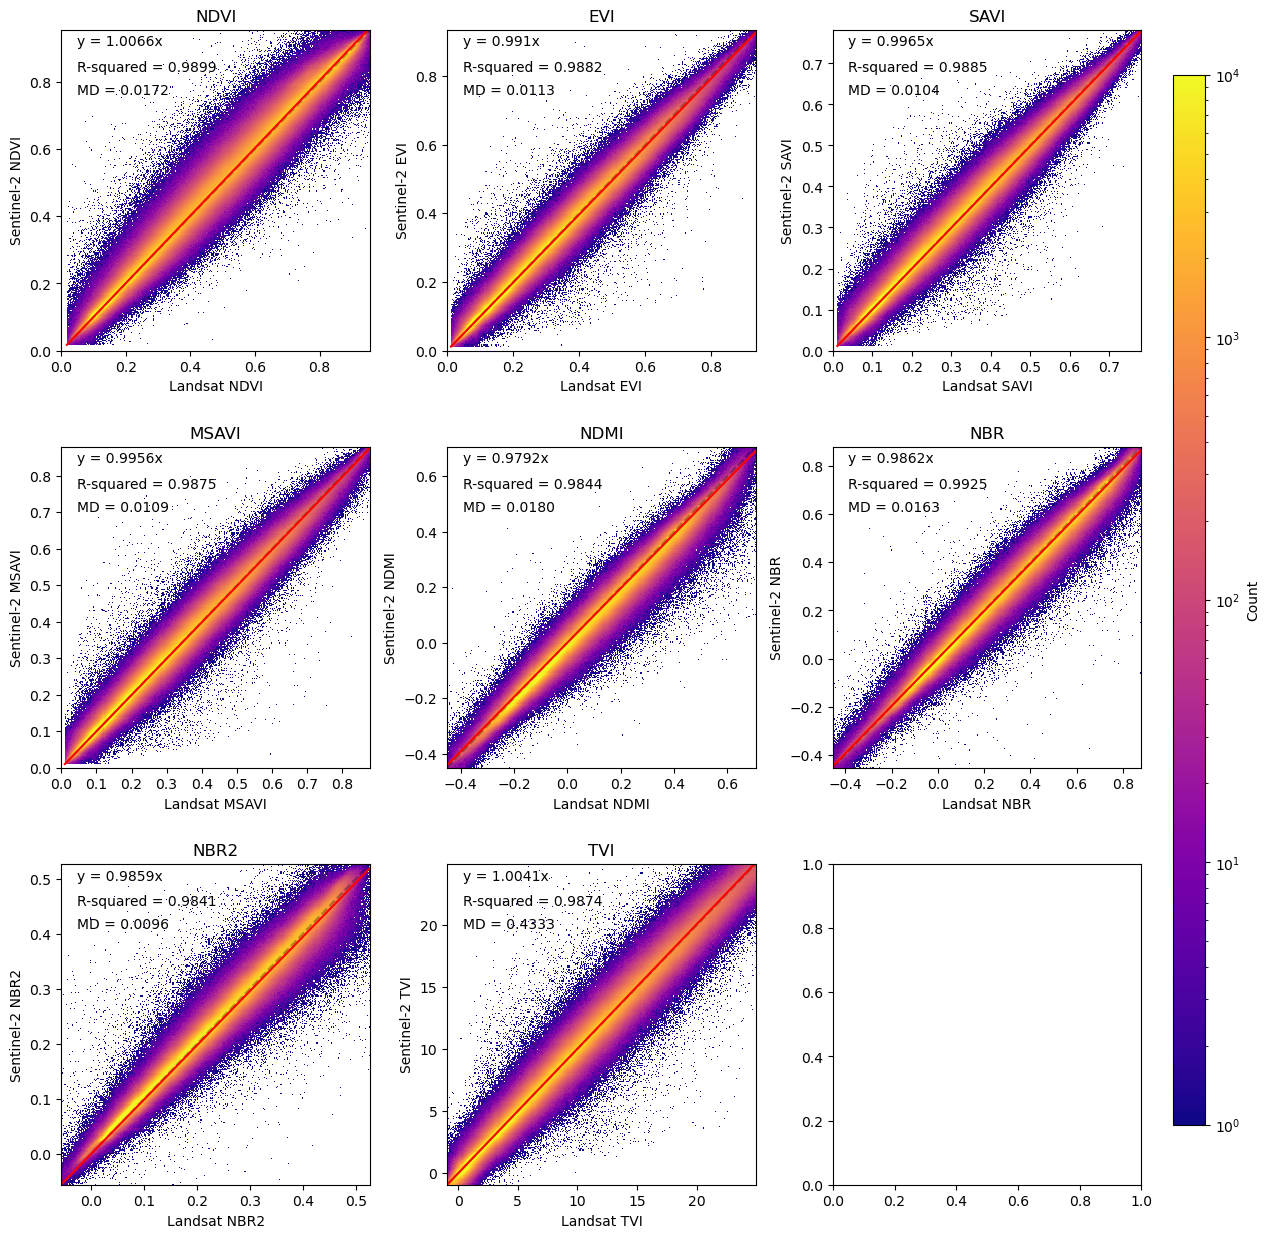

In [34]:
indexes = ["NDVI", "EVI", "SAVI", "MSAVI", "NDMI", "NBR", "NBR2", "TVI"]# , "NDWI"
# indexes = ["NDVI"]
# indexes = ["NDVI", "NDMI", "NDWI"]
# sample_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'
# # toa_mask_dir = os.path.join(sample_dir, "TOA_outlier_mask.npy")
# # toa_mask = np.load(toa_mask_dir).astype(bool)
# snow_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_snow_mask.npy"
# snow_mask = np.load(snow_dir)#.astype(bool)
# # lc_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\MODIS_LC_2020\Layer1\Merged_filtered_samp_LC_LC.npy"
# # lc_mask = np.load(lc_dir)#.astype(bool)
# comb_mask = snow_mask# * water_mask # * (lc_mask == 1)  toa_mask * 
# # print('input mask shape: ', toa_mask.shape, snow_mask.shape, lc_mask.shape)

sample_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'
# toa_mask_dir = os.path.join(sample_dir, "TOA_outlier_mask.npy")
# toa_mask = np.load(toa_mask_dir).astype(bool)
snow_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_snow_mask.npy"
snow_mask = np.load(snow_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask))
water_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_water_mask.npy"
water_mask = np.load(water_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask * water_mask))
date_path = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_Date.npy"
date_arr = np.load(date_path)
tile_path = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_Tile.npy"
tile_arr = np.load(tile_path)
tile_list = np.asarray([ID2TILE[t] for t in tile_arr])
tile_ex = [('11SPV', 2021285), ('55HEU', 2021009), ('55JGH', 2022012), 
              ('55JGH', 2022172), ('55JGH', 2022332), ('55JHM', 2021137),
             ('55JHM', 2021217)]
tile_mask = np.zeros_like(snow_mask, dtype=bool)
for t in tile_ex:
    tile_mask = tile_mask | ((date_arr == t[1]) * (tile_list == t[0]))
# tile_mask = (date_arr == 2021285) * (tile_list == "11SPV")
comb_mask = snow_mask * water_mask * ~tile_mask #toa_mask * 
print("Total number of valid samples pairs: ", np.sum(comb_mask))


# Normalized Difference Vegetation Index(NDVI) = (NIR - R) / (NIR + R)
# Enhanced Vegetation Index(EVI) = 2.5 * ((NIR - R) / (NIR + 6 * R – 7.5 * B + 1))
# Soil Adjusted Vegetation Index(SAVI) = ((NIR - R) / (NIR + R + 0.5)) * (1.5)
# Modified Soil Adjusted Vegetation Index(MSAVI) = (2 * NIR + 1 – sqrt ((2 * NIR + 1)^2 – 8 * (NIR - R))) / 2
# Normalized Difference Moisture Index(NDMI) = (NIR - SWIR1) / (NIR + SWIR1)
# Normalized Burn Ratio(NBR) = (NIR - SWIR2) / (NIR + SWIR2)
# Normalized Burn Ratio2(NBR2) = (SWIR1 – SWIR2) / (SWIR1 + SWIR2)
# Transformed Vegetation Index(TVI) = sqrt(NDVI + 0.5)

# err_idx='rmsd'
err_idx='mad'
n_row = 3
n_col = 3
sample_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\Intermediate\All_samples"
fig, axs = plt.subplots(n_row, n_col, figsize=(16, 15))
plt_vi_scatter(fig, axs, sample_dir, comb_mask, indexes, reg_med='RMA', err_idx=err_idx)
plt.savefig(os.path.join(sample_dir, f'VI_{err_idx}2.png'), dpi=400)

In [ ]:
def plt_vi_byAngle(fig, axs, sample_dir, sample_mask, ind_list, reg_med='OLS', err_idx='rmsd'):
    sub_pop = 0.1
    marker_size = 0.5
    for i, b in enumerate(ind_list):

        l_arr, s_arr = cal_vi(sample_dir, b, "Post Bandpass", sample_mask) #Post Bandpass
        # print('VI range: ', np.percentile(l_arr, 1), np.percentile(s_arr, 1), np.percentile(l_arr, 99), np.percentile(s_arr, 99))
        valid_mask = (l_arr>vi_range[b][0]) * (l_arr<vi_range[b][1]) * (s_arr>vi_range[b][0]) * (s_arr<vi_range[b][1])
        
        water_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_water_mask.npy"
        water_mask = np.load(water_dir)[sample_mask][valid_mask]#.astype(bool)

        l_va_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_L30_view_azimuth.npy"
        l_va_arr = np.load(l_va_dir)[sample_mask][valid_mask][water_mask] * ang_scale
        s_va_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_S30_view_azimuth.npy"
        s_va_arr = np.load(s_va_dir)[sample_mask][valid_mask][water_mask] * ang_scale

        l_arr = l_arr[valid_mask][water_mask]# * mask_ndvi
        s_arr = s_arr[valid_mask][water_mask]# * mask_ndvi

        forward_arr = l_arr[(l_va_arr<180) & (s_va_arr>180)]
        back_arr = s_arr[(l_va_arr<180) & (s_va_arr>180)]
        forward_arr = np.append(forward_arr, s_arr[(l_va_arr>180) & (s_va_arr<180)])
        back_arr = np.append(back_arr, l_arr[(l_va_arr>180) & (s_va_arr<180)])
        del l_arr, s_arr
        print("forward_arr.shape: ", forward_arr.shape, "back_arr.shape: ", back_arr.shape)

        if err_idx=='rmsd':
            msd = np.square(np.subtract(forward_arr, back_arr)).mean()
            rmsd = math.sqrt(msd)
            print('RMSD in terms of forward: ', b, rmsd, rmsd / np.mean(forward_arr), rmsd / np.mean(np.abs(forward_arr)))
        elif err_idx=='mad':
            mad = np.mean(np.abs(forward_arr - back_arr))
            if (b != 'NDMI') and (b != 'NBR'):
                print('MAD in terms of forward: ', b, mad, mad / np.mean(forward_arr), mad / np.mean(np.abs(forward_arr)))
            else:
                print('MAD in terms of forward: ', b, mad, mad / np.mean(forward_arr), mad / np.mean(np.abs(forward_arr)), mad / np.mean([np.abs(np.mean(forward_arr[forward_arr < 0])), np.abs(np.mean(forward_arr[forward_arr > 0]))]))
        else:
            print('err_idx can only be rmsd or mad.')

        if reg_med == 'OLS':
            model = LinearRegression(fit_intercept=False)
            model.fit(forward_arr.reshape(-1, 1), back_arr)
            model_slope = model.coef_[0]
            model_inter = model.intercept_
            y_pred = model.predict(forward_arr.reshape(-1, 1))
        elif reg_med == 'RMA':
            model_dict = rma_regression(forward_arr, back_arr, need_intercept=False)
            print('rma model_dict: ', model_dict)
            print('rma model_dict val: ', rma_regression(back_arr, forward_arr, need_intercept=False))
            # print('model_dict val: ', regress2(s_arr, l_arr.reshape(-1, 1), _method_type_2="reduced major axis", _need_intercept=False))
            model_slope = model_dict[0]
            model_inter = model_dict[1]
            y_pred = model_slope * forward_arr + model_inter
            
            # y_pred = model_dict['predict']
        else:
            print('reg_med can only be OLS or RMA.')

        r2 = r2_score(back_arr, y_pred)
        
        sample_idx = (np.random.rand(forward_arr.shape[0]) < sub_pop)# * (l_arr < 1) * (s_arr < 1)
        forward_arr = forward_arr[sample_idx]
        back_arr = back_arr[sample_idx]
        # kde_arr = kde_arr[sample_idx]

        max_val = max(np.percentile(forward_arr, 99.99), np.percentile(back_arr, 99.99))
        min_val = max(np.percentile(forward_arr, 0.01), np.percentile(back_arr, 0.01))
        print(b, max_val, min_val)
        if min_val > 0:
            x_ann = min_val * 1.3
        else:
            x_ann = min_val * 0.7
        # max_val = max(np.max(l_arr), np.max(s_arr))
        # max_val = min(max_val, 1.0)
        # xy = np.vstack([l_arr, s_arr])
        # z = gaussian_kde(xy)(xy)
        
        # axs[i//n_col, i%n_col].scatter(l_arr, s_arr, c=z, s=marker_size)# kde_arr
        counts, xedges, yedges, im = axs[i//n_col, i%n_col].hist2d(forward_arr, back_arr, bins=300, range=[[min_val,max_val],[min_val,max_val]], cmin=1, norm=colors.LogNorm(vmin=1,vmax=1e+4), cmap = cm.plasma)
        axs[i//n_col, i%n_col].set_title(b)
        axs[i//n_col, i%n_col].set_xlim((min_val, max_val))
        axs[i//n_col, i%n_col].set_ylim((min_val, max_val))
        ticks = axs[i//n_col, i%n_col].get_yticks()
        if (ticks[0] < 0) & (ticks[0] < min_val):
            ticks = ticks[1:]
        if ticks[-1] > max_val:
            ticks = ticks[:-1]
        axs[i//n_col, i%n_col].set_xticks(ticks)
        axs[i//n_col, i%n_col].set_yticks(ticks)
        print(axs[i//n_col, i%n_col].get_yticks())
        axs[i//n_col, i%n_col].set_xlabel(f'VA<180 view {b}')
        axs[i//n_col, i%n_col].set_ylabel(f'VA>180 view {b}')
        axs[i//n_col, i%n_col].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
        xseq = np.linspace(min_val, max_val, num=10)
        if err_idx == 'rmsd':
            axs[i//n_col, i%n_col].annotate(f"RMSD = {np.round(rmsd, 4):.4f}", xy=(0.05, 0.8), xycoords='axes  fraction')
        elif err_idx == 'mad':
            axs[i//n_col, i%n_col].annotate(f"MD = {np.round(mad, 4):.4f}", xy=(0.05, 0.8), xycoords='axes  fraction') #xy=(x_ann, max_val * 0.79)
        else:
            print('err_idx can only be rmsd or mad.')
        if reg_med == 'OLS':
            axs[i//n_col, i%n_col].plot(xseq, model.predict(xseq.reshape(-1, 1)), color="r")
        elif reg_med == 'RMA':
            axs[i//n_col, i%n_col].plot(xseq, model_slope * xseq + model_inter, color="r")
        else:
            print('reg_med can only be OLS or RMA.')
        if model_inter >= 0:
            axs[i//n_col, i%n_col].annotate(f"y = {np.round(model_slope, 4)}x", xy=(0.05, 0.95), xycoords='axes  fraction') #+{np.round(model.intercept_, 4)}
        else:
            axs[i//n_col, i%n_col].annotate(f"y = {np.round(model_slope, 4)}x", xy=(0.05, 0.95), xycoords='axes  fraction') #{np.round(model.intercept_, 4)}
        axs[i//n_col, i%n_col].annotate(f"R-squared = {np.round(r2, 4)}", xy=(0.05, 0.87), xycoords='axes  fraction')
        
    # fig.delaxes(axs[n_row-1][n_col-1])
    fig.subplots_adjust(right=0.8, wspace=0.25, hspace=0.3)
    cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    fig.colorbar(im, cax=cbar_ax).set_label('Count')
    # fig.suptitle(b, fontsize=30)
    # plt.tight_layout()


indexes = ["NDVI", "EVI", "SAVI", "MSAVI", "NDMI", "NBR", "NBR2", "TVI"]# , "NDWI"
sample_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'
# toa_mask_dir = os.path.join(sample_dir, "TOA_outlier_mask.npy")
# toa_mask = np.load(toa_mask_dir).astype(bool)
snow_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_snow_mask.npy"
snow_mask = np.load(snow_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask))
water_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_water_mask.npy"
water_mask = np.load(water_dir)#.astype(bool)
# print(np.sum(toa_mask * snow_mask * water_mask))
date_path = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_Date.npy"
date_arr = np.load(date_path)
tile_path = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\Merged_filtered_samp_Tile.npy"
tile_arr = np.load(tile_path)
tile_list = np.asarray([ID2TILE[t] for t in tile_arr])
tile_ex = [('11SPV', 2021285), ('55HEU', 2021009), ('55JGH', 2022012), 
              ('55JGH', 2022172), ('55JGH', 2022332), ('55JHM', 2021137),
             ('55JHM', 2021217)]
tile_mask = np.zeros_like(snow_mask, dtype=bool)
for t in tile_ex:
    tile_mask = tile_mask | ((date_arr == t[1]) * (tile_list == t[0]))
# tile_mask = (date_arr == 2021285) * (tile_list == "11SPV")
comb_mask = snow_mask * water_mask * ~tile_mask #toa_mask * 
print("Total number of valid samples pairs: ", np.sum(comb_mask))

# err_idx='rmsd'
err_idx='mad'
n_row = 3
n_col = 3
sample_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\Intermediate\All_samples"
fig, axs = plt.subplots(n_row, n_col, figsize=(16, 15))
plt_vi_byAngle(fig, axs, sample_dir, comb_mask, indexes, reg_med='RMA', err_idx=err_idx)
plt.savefig(os.path.join(sample_dir, f'VI_{err_idx}2_byAngle.png'), dpi=400)

Total number of valid samples pairs:  160253969


C:\Users\qzhou2\AppData\Local\Temp\1\ipykernel_16996\973816350.py:3: RuntimeWarning: divide by zero encountered in divide
  arr = (nir_arr - red_arr) / (nir_arr + red_arr)


forward_arr.shape:  (64837242,) back_arr.shape:  (64837242,)
MAD in terms of forward:  NDVI 0.018493042749504376 0.03902382562350856 0.03902358240559877
[[0.06199753 0.06195168]
 [0.06195168 0.06267929]]
rma model_dict:  (1.0054832491328685, 0)
[[0.06267929 0.06195168]
 [0.06195168 0.06199753]]
rma model_dict val:  (0.9945466529277367, 0)
NDVI 0.9670035689263212 0.014042999033139669
[0.  0.2 0.4 0.6 0.8]
forward_arr.shape:  (64676648,) back_arr.shape:  (64676648,)
MAD in terms of forward:  EVI 0.012624465014746383 0.04569661084340248 0.04569621538541401
[[0.02595747 0.02545194]
 [0.02545194 0.02529252]]
rma model_dict:  (0.9871083804211028, 0)
[[0.02529252 0.02545194]
 [0.02545194 0.02595747]]
rma model_dict val:  (1.0130599839233434, 0)
EVI 0.928345766410985 0.009798730202372317
[0.  0.2 0.4 0.6 0.8]
forward_arr.shape:  (64838174,) back_arr.shape:  (64838174,)
MAD in terms of forward:  SAVI 0.0112457615091326 0.04050944555170643 0.04050919113120745
[[0.02110781 0.02089175]
 [0.0208917

C:\Users\qzhou2\AppData\Local\Temp\1\ipykernel_16996\973816350.py:26: RuntimeWarning: invalid value encountered in sqrt
  arr = (2 * nir_arr + 1 - np.sqrt(np.square(2 * nir_arr + 1) - 8 * (nir_arr - red_arr))) / 2


forward_arr.shape:  (64838174,) back_arr.shape:  (64838174,)
MAD in terms of forward:  MSAVI 0.011983695539607687 0.04609125173642165 0.04609097343944564
[[0.02338408 0.02311953]
 [0.02311953 0.0231823 ]]
rma model_dict:  (0.9956763133155361, 0)
[[0.0231823  0.02311953]
 [0.02311953 0.02338408]]
rma model_dict val:  (1.004342462130154, 0)
MSAVI 0.8763051219976014 0.009059123389509052
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
forward_arr.shape:  (64849055,) back_arr.shape:  (64849055,)
MAD in terms of forward:  NDMI 0.019340103896339354 0.4462811061454954 0.1169869458351803 0.11600171283317616
[[0.0398313  0.04011801]
 [0.04011801 0.04112239]]
rma model_dict:  (1.0160777328101402, 0)
[[0.04112239 0.04011801]
 [0.04011801 0.0398313 ]]
rma model_dict val:  (0.9841766704544599, 0)
NDMI 0.7226799835245372 -0.444796453483486
[-0.4 -0.2  0.   0.2  0.4  0.6]


C:\Users\qzhou2\AppData\Local\Temp\1\ipykernel_16996\973816350.py:41: RuntimeWarning: divide by zero encountered in divide
  arr = (nir_arr - swir2_arr) / (nir_arr + swir2_arr)


forward_arr.shape:  (64848876,) back_arr.shape:  (64848876,)
MAD in terms of forward:  NBR 0.01766200297794211 0.07163520094778057 0.06314772001197724 0.08494119933600638
[[0.07195783 0.07227407]
 [0.07227407 0.07327114]]
rma model_dict:  (1.009084304744456, 0)
[[0.07327114 0.07227407]
 [0.07227407 0.07195783]]
rma model_dict val:  (0.9909974769186837, 0)
NBR 0.8932837216999714 -0.45080297018818516
[-0.4 -0.2  0.   0.2  0.4  0.6  0.8]


C:\Users\qzhou2\AppData\Local\Temp\1\ipykernel_16996\973816350.py:49: RuntimeWarning: divide by zero encountered in divide
  arr = (swir1_arr - swir2_arr) / (swir1_arr + swir2_arr)
C:\Users\qzhou2\AppData\Local\Temp\1\ipykernel_16996\973816350.py:49: RuntimeWarning: invalid value encountered in divide
  arr = (swir1_arr - swir2_arr) / (swir1_arr + swir2_arr)


forward_arr.shape:  (64848400,) back_arr.shape:  (64848400,)
MAD in terms of forward:  NBR2 0.01035608925539379 0.04588828255564903 0.04587584765941174
[[0.01324822 0.01323448]
 [0.01323448 0.01343645]]
rma model_dict:  (1.0070787586367795, 0)
[[0.01343645 0.01323448]
 [0.01323448 0.01324822]]
rma model_dict val:  (0.9929709979720339, 0)
NBR2 0.5251590026772635 -0.058602114421819604
[0.  0.1 0.2 0.3 0.4 0.5]
forward_arr.shape:  (63702955,) back_arr.shape:  (63702955,)
MAD in terms of forward:  TVI 0.46824014901663497 0.05622011568478019 0.05615695178238272
[[32.02706859 31.49029374]
 [31.49029374 31.41948293]]
rma model_dict:  (0.9904690784940025, 0)
[[31.41948293 31.49029374]
 [31.49029374 32.02706859]]
rma model_dict val:  (1.0096226340760575, 0)
TVI 24.964 -0.9460000000000007


# Strata Veg

In [48]:
def plt_vi_scatter_stra(fig, axs, sample_dir, sample_mask, index):
    sub_pop = 0.01
    marker_size = 0.5
    l_path = os.path.join(sample_dir, f"Merged_filtered_samp_L30_sr_nbar_NDVI.npy")
    l_ndvi = np.load(l_path)[sample_mask]
    s_path = os.path.join(sample_dir, f"Merged_filtered_samp_S30_sr_nbar_bp_NDVI.npy")
    s_ndvi = np.load(s_path)[sample_mask]
    mask_ndvi = (l_ndvi > 0.2) * (l_ndvi < 1.0) * (s_ndvi > 0.2) * (s_ndvi < 1.0)
    lc_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\MODIS_LC_2020\Layer1\Merged_filtered_samp_LC_LC.npy"
    lc_mask = np.load(lc_dir)#.astype(bool)
    # for i, b in enumerate(ind_list):
    for i in range(10):
        l_path = os.path.join(sample_dir, f"Merged_filtered_samp_L30_sr_nbar_{index}.npy")
        l_arr = np.load(l_path)[sample_mask * (lc_mask == i + 1)]
        s_path = os.path.join(sample_dir, f"Merged_filtered_samp_S30_sr_nbar_bp_{index}.npy")
        s_arr = np.load(s_path)[sample_mask * (lc_mask == i + 1)]

        # sample_mask = sample_mask * (lc_mask == i + 1)
        
        sample_idx = (np.random.rand(l_arr.shape[0]) < sub_pop) * np.isfinite(l_arr) * np.isfinite(s_arr)
        # print("Plot number of samples: ", np.sum(sample_idx))
        l_arr = l_arr[sample_idx]
        s_arr = s_arr[sample_idx]

        xy = np.vstack([l_arr, s_arr])
        z = gaussian_kde(xy)(xy)
        
        max_val = max(np.percentile(l_arr, 99), np.percentile(s_arr, 99))
        min_val = max(np.percentile(l_arr, 1), np.percentile(s_arr, 1))
        # mse = np.square(np.subtract(l_arr, s_arr)).mean()
        # rmse = math.sqrt(mse)
        mad = np.mean(np.abs(l_arr - s_arr))
        axs[i//n_col, i%n_col].scatter(l_arr, s_arr, c=z, s=marker_size)#
        axs[i//n_col, i%n_col].annotate(f"MAD = {np.round(mad, 3)}", xy=((max_val + min_val) * 0.6, (max_val + min_val) * 0.3))
        axs[i//n_col, i%n_col].set_title(IGBP_LC[i + 1])
        axs[i//n_col, i%n_col].set_xlim((min_val, max_val))
        axs[i//n_col, i%n_col].set_ylim((min_val, max_val))
        axs[i//n_col, i%n_col].set_xlabel(f'Landsat {index}')
        axs[i//n_col, i%n_col].set_ylabel(f'Sentinel-2 {index}')
        axs[i//n_col, i%n_col].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)

    # fig.delaxes(axs[n_row-1][n_col-1])
    # fig.suptitle(b, fontsize=30)
    plt.tight_layout()

In [ ]:
indexes = ["NDVI", "EVI", "SAVI", "MSAVI", "NDMI", "NBR", "NBR2", "TVI"]
IGBP_LC = {1: 'Evergreen needleleaf forests',
            2: 'Evergreen broadleaf forest',
            3: 'Deciduous needleleaf forests',
            4: 'Deciduous broadleaf forests',
            5: 'Mixed forests',
            6: 'Closed shrublands',
            7: 'Open shrublands',
            8: 'Wood savannas',
            9: 'Savannas',
            10: 'Grasslands'}

sample_dir = r'C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples'
toa_mask_dir = os.path.join(sample_dir, "TOA_outlier_mask.npy")
toa_mask = np.load(toa_mask_dir).astype(bool)
snow_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\TOA\All_samples\intersect_snow_mask.npy"
snow_mask = np.load(snow_dir)#.astype(bool)
lc_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\MODIS_LC_2020\Layer1\Merged_filtered_samp_LC_LC.npy"
lc_mask = np.load(lc_dir)#.astype(bool)
comb_mask = toa_mask * snow_mask# * (lc_mask == 1)
# print('input mask shape: ', toa_mask.shape, snow_mask.shape, lc_mask.shape)

n_row = 2
n_col = 5
index = "NDVI"
sample_dir = r"C:\Users\qzhou2\C_workdir\Goden_tile\Intermediate\All_samples"
fig, axs = plt.subplots(n_row, n_col, figsize=(15, 6))
plt_vi_scatter_stra(fig, axs, sample_dir, comb_mask, index)
# plt.savefig(os.path.join(sample_dir, 'VI.png'), dpi=400)

# Time series

<AxesSubplot:xlabel='Date'>

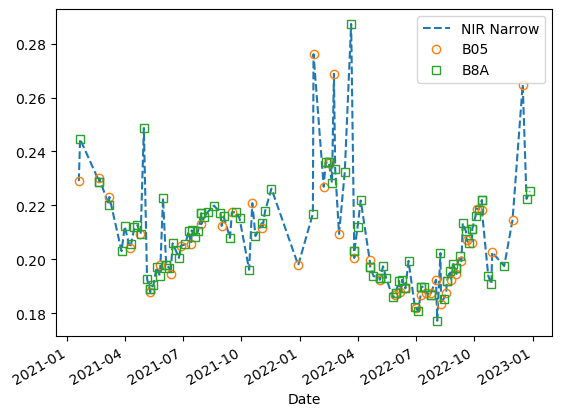

In [39]:
df_l8_path = r'C:\Users\qzhou2\C_workdir\Goden_tile\TS\ts_sample_L30_647704_-2954792_mp.csv'
df_l8 = pd.read_csv(df_l8_path)
df_s2_path = r'C:\Users\qzhou2\C_workdir\Goden_tile\TS\ts_sample_S30_647704_-2954792_mp.csv'
df_s2 = pd.read_csv(df_s2_path)
# print(df_l8.head())
# print(df_s2.head())
# l8_col = ['L30_date', 'L30_B01', 'L30_B11', 'L30_ACmask', 'L30_Fmask', 'L30_B02', 'L30_B03', 'L30_B04', 'L30_B05', 'L30_B06', 'L30_B07', 'L30_B09', 'L30_B10']
# s2_col = ['S30_date', 'S30_B01', 'S30_B09', 'S30_B10', 'S30_B11', 'S30_B12', 'S30_ACmask', 'S30_Fmask', 'S30_B02', 'S30_B03', 'S30_B04', 'S30_B05', 'S30_B06', 'S30_B07', 'S30_B08', 'S30_B8A']

# df_l8 = df[l8_col].dropna()
# df_s2 = df[s2_col].dropna()
df_l8['Date']= pd.to_datetime(df_l8['Date'])
df_s2['Date']= pd.to_datetime(df_s2['Date'])

df_l8['mask'] = mask_hls(df_l8['Fmask'].astype(int))
df_s2['mask'] = mask_hls(df_s2['Fmask'].astype(int))
df_l8 = df_l8[df_l8['mask'] == 0]
df_s2 = df_s2[df_s2['mask'] == 0]

plt_band = "B05"
ax = plt.gca()
df_all = df_l8[['Date', plt_band]].rename(columns={plt_band: L8_bandname[plt_band]})#
df_all = df_all.append(df_s2[['Date', L8_2_S2[plt_band]]].rename(columns={L8_2_S2[plt_band]: L8_bandname[plt_band]}))
df_all.plot(x='Date', y=L8_bandname[plt_band], style='--', ax=ax)      
df_l8.plot(x='Date', y=plt_band, style='o', fillstyle='none', ax=ax)
df_s2.plot(x='Date', y=L8_2_S2[plt_band], style='s', fillstyle='none', ax=ax)